In [1]:
# Why choose this data?
# Healthcare more rely on model confidence.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, balanced_accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import shap

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Data preparation

*  Data preprocessing:
    * Impute Missing values with median(column 'bmi')
    * Drop column 'id'
    * Transform categorical data with one-hot encoding; numerical data with standardization

In [3]:
data = pd.read_csv('./data/Tabular/healthcare-dataset-stroke-data.csv')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    data.loc[:,data.columns != 'stroke'], data['stroke'], test_size=0.2, stratify = data['stroke'], random_state=5566)

In [5]:
# Missing values
X_train.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  160
smoking_status         0
dtype: int64

In [6]:
X_train.fillna(X_train['bmi'].median(), inplace = True)

In [7]:
# Impute Missing values
X_train.fillna(X_train['bmi'].median(), inplace = True)
# Drop Column
X_train = X_train.drop(['id'], axis=1)
# Map values
map_dict = {0:'No', 1:'Yes'}
X_train['hypertension'] = X_train.hypertension.map(map_dict)
X_train['heart_disease'] = X_train.heart_disease.map(map_dict)

In [8]:
transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns),
    (StandardScaler(), X_train.select_dtypes(exclude='object').columns),
    remainder='passthrough')

In [9]:
transformer.fit(X_train);

In [10]:
trans_col = [col.split('__')[1] for col in transformer.get_feature_names_out()]

In [11]:
X_train_trans = transformer.transform(X_train)

In [12]:
X_test_id = X_test['id'].reset_index(drop = True)
X_test = X_test.drop(['id'], axis=1)
X_test.fillna(X_test['bmi'].median(), inplace = True)
# Map values
map_dict = {0:'No', 1:'Yes'}
X_test['hypertension'] = X_test.hypertension.map(map_dict)
X_test['heart_disease'] = X_test.heart_disease.map(map_dict)

In [13]:
X_test_trans = transformer.transform(X_test)

In [14]:
def performance_eval(y_true, y_pred):
    classes = [0, 1]
    print('Avg Recall: {:.2f}'.format(balanced_accuracy_score(y_true, y_pred)))
    print('Precision:  {:.2f}'.format(precision_score(y_true, y_pred)))
    print('Recall:  {:.2f}'.format(recall_score(y_true, y_pred)))
    cm = cm = confusion_matrix(y_true, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=classes)
    disp.plot()

# Shap for XGBoost

In [15]:
import xgboost as xgb

In [16]:
categorical_features_name = X_train.select_dtypes(include=['object']).columns
categorical_features_index = np.where(X_train.columns.isin(categorical_features_name))[0]

In [17]:
categorical_names = {}
for index in categorical_features_index:
    le = LabelEncoder()
    le.fit(X_train.iloc[:, index])
    tle = LabelEncoder()
    tle.fit(X_test.iloc[:, index])
    X_train.iloc[:, index] = le.transform(X_train.iloc[:, index])
    X_test.iloc[:, index] = tle.transform(X_test.iloc[:, index])
    categorical_names[index] = le.classes_

In [18]:
best_xgb = xgb.XGBClassifier(objective="binary:logistic",
                             eval_metric="auc",
                             learning_rate=0.01,
                             max_depth=5,
                             n_estimators=250,
                             n_jobs=-1,
                             verbosity=0,
                             random_state=5566)

In [19]:
encoder = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(handle_unknown = 'ignore'), categorical_features_index)],    # The column numbers to be transformed (here is [0] but can be [0, 1, 3])
    remainder='passthrough'                         # Leave the rest of the columns untouched
)

In [20]:
encoder.fit(X_train)
encoded_train = encoder.transform(X_train)
encoded_test = encoder.transform(X_test)

In [21]:
best_xgb.fit(encoded_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=250, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=5566, ...)

In [22]:
xgb_pred = best_xgb.predict(encoded_train)

Avg Recall: 0.52
Precision:  1.00
Recall:  0.04


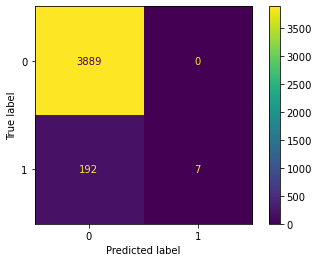

In [23]:
performance_eval(y_train, xgb_pred)

In [24]:
pd.DataFrame(encoded_test, columns=trans_col)

gender_Female  gender_Male  hypertension_No  hypertension_Yes  \
0               1.0          0.0              0.0               1.0   
1               0.0          1.0              1.0               0.0   
2               0.0          1.0              0.0               1.0   
3               1.0          0.0              1.0               0.0   
4               0.0          1.0              0.0               1.0   
...             ...          ...              ...               ...   
1017            0.0          1.0              1.0               0.0   
1018            1.0          0.0              1.0               0.0   
1019            0.0          1.0              1.0               0.0   
1020            1.0          0.0              0.0               1.0   
1021            1.0          0.0              1.0               0.0   

      heart_disease_No  heart_disease_Yes  ever_married_No  ever_married_Yes  \
0                  1.0                0.0              0.0               1.0   
1                  0.0                1.0              1.0               0.0   
2                  0.0                1.0              0.0               1.0   
3                  1.0                0.0              1.0               0.0   
4                  1.0                0.0              0.0               1.0   
...                ...                ...              ...               ...   
1017               1.0                0.0              0.0               1.0   
1018               1.0                0.0              0.0               1.0   
1019               0.0                1.0              0.0               1.0   
1020               1.0                0.0              0.0               1.0   
1021               1.0                0.0              0.0               1.0   

      work_type_Govt_job  work_type_Never_worked  ...  work_type_children  \
0                    0.0                     0.0  ...                 0.0   
1                    0.0                     0.0  ...                 0.0   
2                    0.0                     0.0  ...                 0.0   
3                    1.0                     0.0  ...                 0.0   
4                    0.0                     0.0  ...                 0.0   
...                  ...                     ...  ...                 ...   
1017                 0.0                     0.0  ...                 0.0   
1018                 1.0                     0.0  ...                 0.0   
1019                 0.0                     0.0  ...                 0.0   
1020                 0.0                     0.0  ...                 0.0   
1021                 0.0                     0.0  ...                 0.0   

      Residence_type_Rural  Residence_type_Urban  smoking_status_Unknown  \
0                      0.0                   1.0                     0.0   
1                      1.0                   0.0                     0.0   
2                      0.0                   1.0                     0.0   
3                      0.0                   1.0                     0.0   
4                      1.0                   0.0                     0.0   
...                    ...                   ...                     ...   
1017                   1.0                   0.0                     0.0   
1018                   1.0                   0.0                     0.0   
1019                   0.0                   1.0                     0.0   
1020                   0.0                   1.0                     0.0   
1021                   1.0                   0.0                     0.0   

      smoking_status_formerly smoked  smoking_status_never smoked  \
0                                1.0                          0.0   
1                                1.0                          0.0   
2                                0.0                          1.0   
3                                1.0                          0.0   
4        

In [25]:
pd.DataFrame(X_test_trans, columns=trans_col)

gender_Female  gender_Male  hypertension_No  hypertension_Yes  \
0               1.0          0.0              0.0               1.0   
1               0.0          1.0              1.0               0.0   
2               0.0          1.0              0.0               1.0   
3               1.0          0.0              1.0               0.0   
4               0.0          1.0              0.0               1.0   
...             ...          ...              ...               ...   
1017            0.0          1.0              1.0               0.0   
1018            1.0          0.0              1.0               0.0   
1019            0.0          1.0              1.0               0.0   
1020            1.0          0.0              0.0               1.0   
1021            1.0          0.0              1.0               0.0   

      heart_disease_No  heart_disease_Yes  ever_married_No  ever_married_Yes  \
0                  1.0                0.0              0.0               1.0   
1                  0.0                1.0              1.0               0.0   
2                  0.0                1.0              0.0               1.0   
3                  1.0                0.0              1.0               0.0   
4                  1.0                0.0              0.0               1.0   
...                ...                ...              ...               ...   
1017               1.0                0.0              0.0               1.0   
1018               1.0                0.0              0.0               1.0   
1019               0.0                1.0              0.0               1.0   
1020               1.0                0.0              0.0               1.0   
1021               1.0                0.0              0.0               1.0   

      work_type_Govt_job  work_type_Never_worked  ...  work_type_children  \
0                    0.0                     0.0  ...                 0.0   
1                    0.0                     0.0  ...                 0.0   
2                    0.0                     0.0  ...                 0.0   
3                    1.0                     0.0  ...                 0.0   
4                    0.0                     0.0  ...                 0.0   
...                  ...                     ...  ...                 ...   
1017                 0.0                     0.0  ...                 0.0   
1018                 1.0                     0.0  ...                 0.0   
1019                 0.0                     0.0  ...                 0.0   
1020                 0.0                     0.0  ...                 0.0   
1021                 0.0                     0.0  ...                 0.0   

      Residence_type_Rural  Residence_type_Urban  smoking_status_Unknown  \
0                      0.0                   1.0                     0.0   
1                      1.0                   0.0                     0.0   
2                      0.0                   1.0                     0.0   
3                      0.0                   1.0                     0.0   
4                      1.0                   0.0                     0.0   
...                    ...                   ...                     ...   
1017                   1.0                   0.0                     0.0   
1018                   1.0                   0.0                     0.0   
1019                   0.0                   1.0                     0.0   
1020                   0.0                   1.0                     0.0   
1021                   1.0                   0.0                     0.0   

      smoking_status_formerly smoked  smoking_status_never smoked  \
0                                1.0                          0.0   
1                                1.0                          0.0   
2                                0.0                          1.0   
3                                1.0                          0.0   
4        

In [26]:
X_test_final = pd.DataFrame(encoded_test, columns=trans_col)
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer(X_test_final)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


## XGBoost importance

In [28]:
Imp_xgb = xgb.XGBClassifier(objective="binary:logistic",
                             eval_metric="auc",
                             learning_rate=0.01,
                             max_depth=5,
                             n_estimators=250,
                             n_jobs=-1,
                             verbosity=0,
                             random_state=5566)

In [29]:
Imp_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=250, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=5566, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

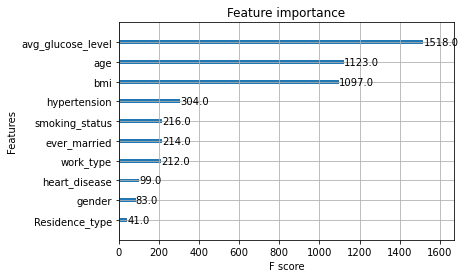

In [30]:
xgb.plot_importance(Imp_xgb)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

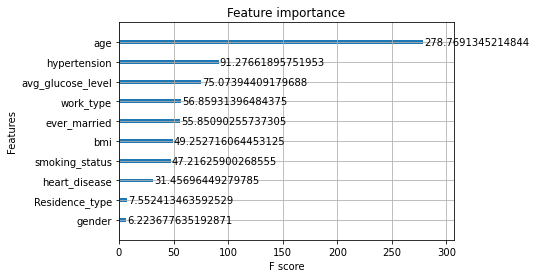

In [31]:
xgb.plot_importance(Imp_xgb, importance_type="cover")

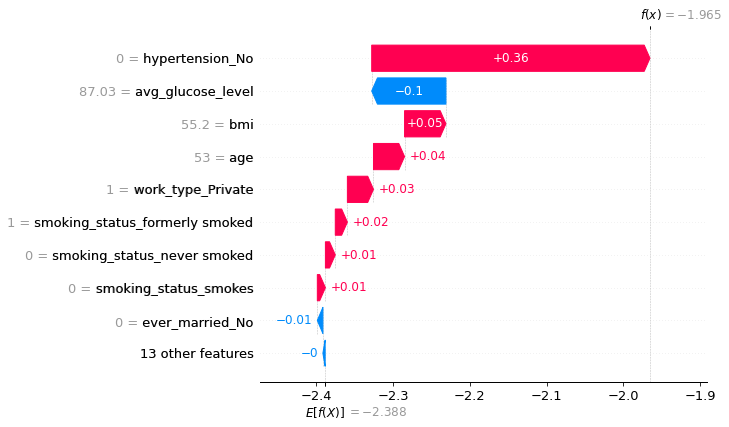

In [28]:
shap.plots.waterfall(shap_values[0])

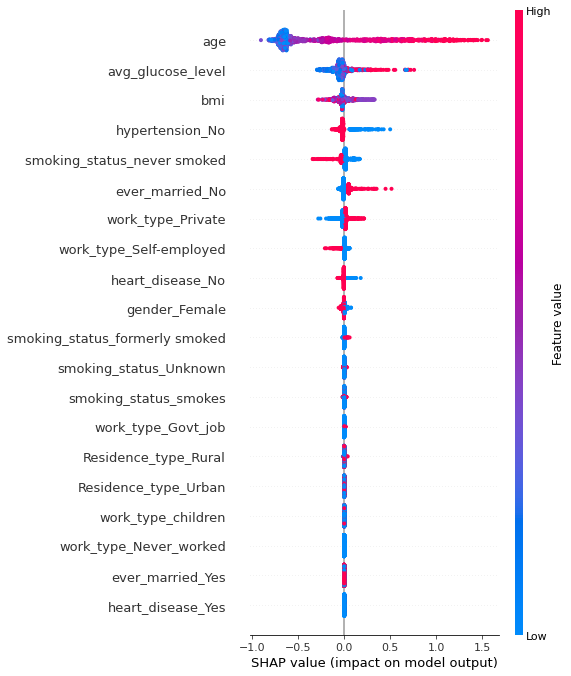

In [32]:
shap.summary_plot(shap_values, X_test_final)

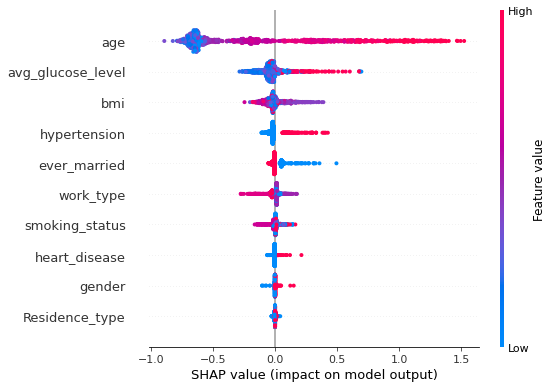

In [26]:
shap.summary_plot(shap_values, X_test)

## Check Stroke

In [29]:
y_test = y_test.reset_index(drop=True)

In [30]:
xgb_pred_test = best_xgb.predict_proba(X_test_final)

In [32]:
X_test_id

0       15220
1       66196
2       15415
3       15018
4        6233
        ...  
1017    27479
1018    54338
1019    31091
1020    23368
1021     3673
Name: id, Length: 1022, dtype: int64

Patient id: 36255
         [Non-stroke, Stroke]
Predict: [0.87939274 0.12060724]


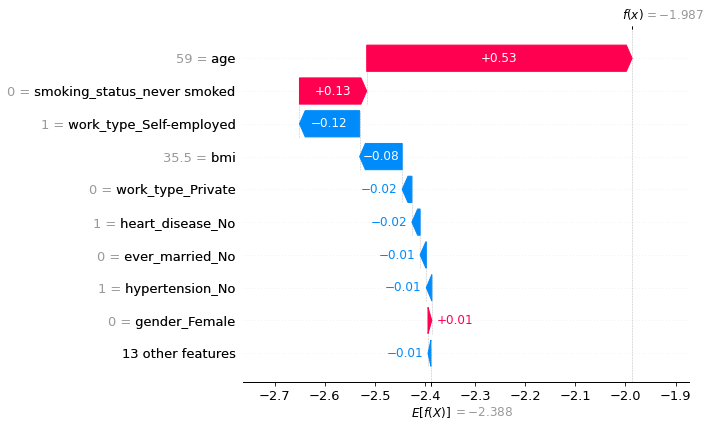

Patient id: 39373
         [Non-stroke, Stroke]
Predict: [0.7941427  0.20585729]


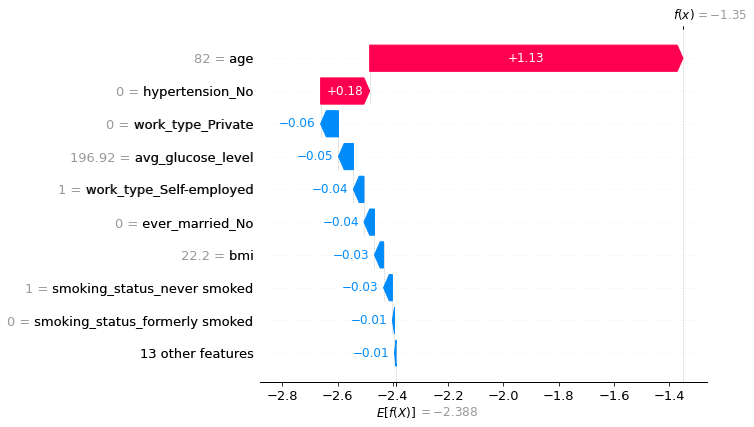

Patient id: 48796
         [Non-stroke, Stroke]
Predict: [0.7811903 0.2188097]


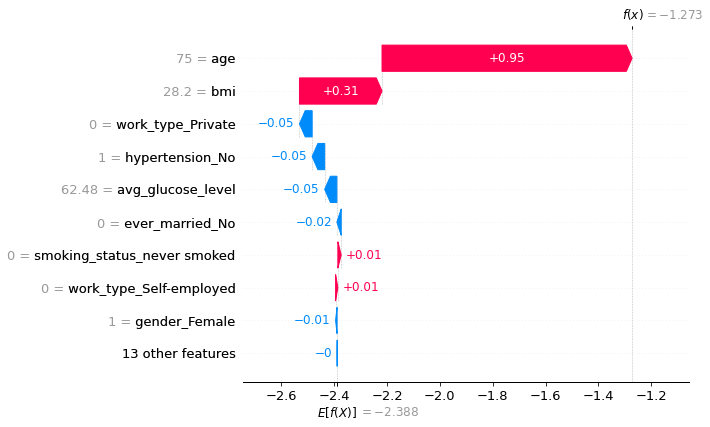

Patient id: 59190
         [Non-stroke, Stroke]
Predict: [0.7654866 0.2345134]


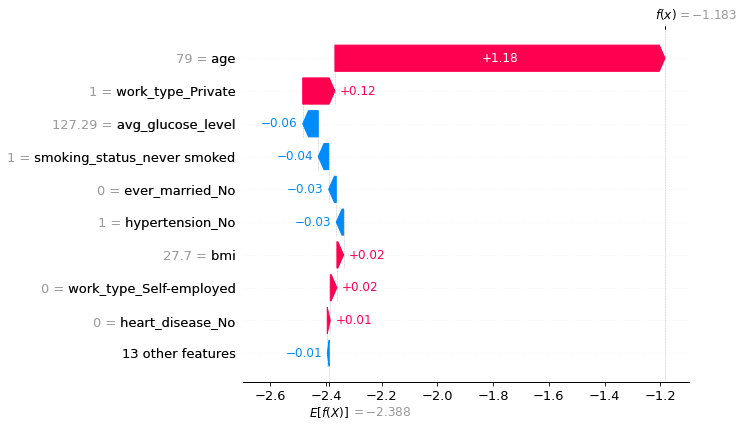

Patient id: 24669
         [Non-stroke, Stroke]
Predict: [0.6778446  0.32215542]


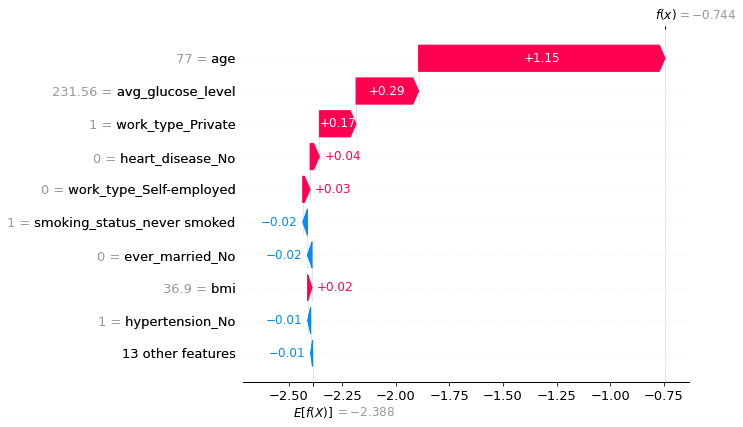

Patient id: 51676
         [Non-stroke, Stroke]
Predict: [0.8657713 0.1342287]


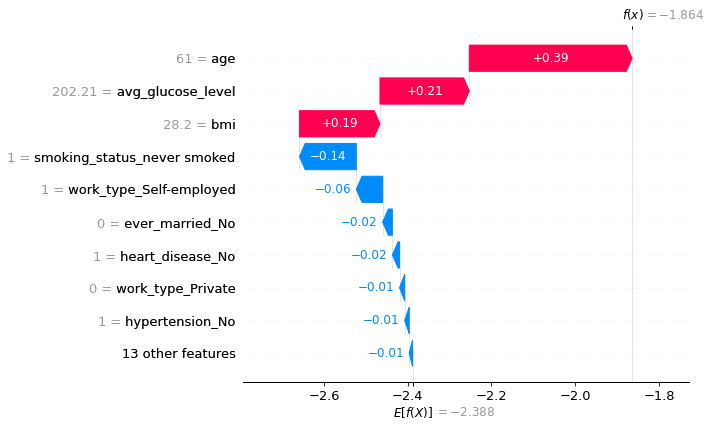

Patient id: 40460
         [Non-stroke, Stroke]
Predict: [0.57126766 0.42873234]


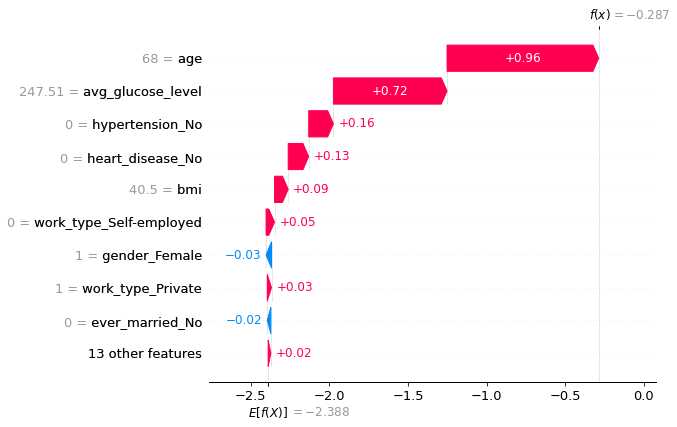

Patient id: 63453
         [Non-stroke, Stroke]
Predict: [0.93545145 0.06454855]


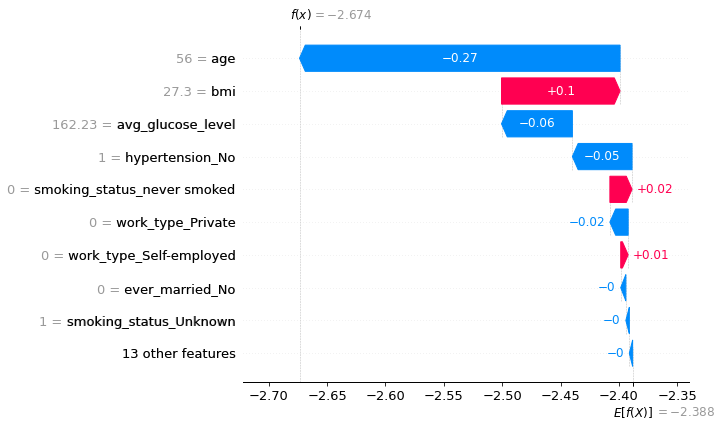

Patient id: 16590
         [Non-stroke, Stroke]
Predict: [0.81778634 0.18221368]


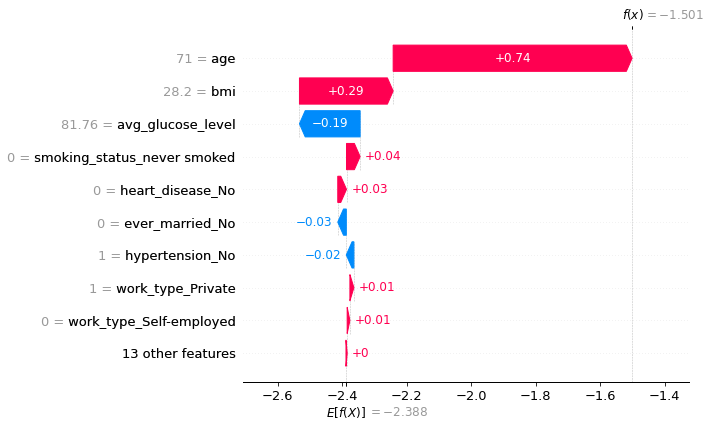

Patient id: 68798
         [Non-stroke, Stroke]
Predict: [0.8403415 0.1596585]


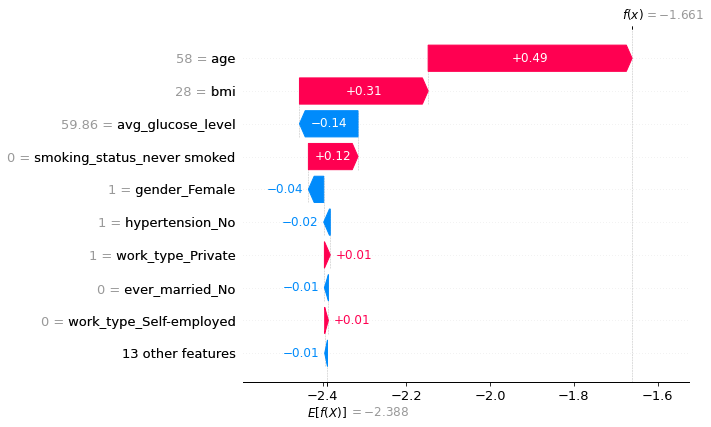

Patient id: 10710
         [Non-stroke, Stroke]
Predict: [0.9398946  0.06010536]


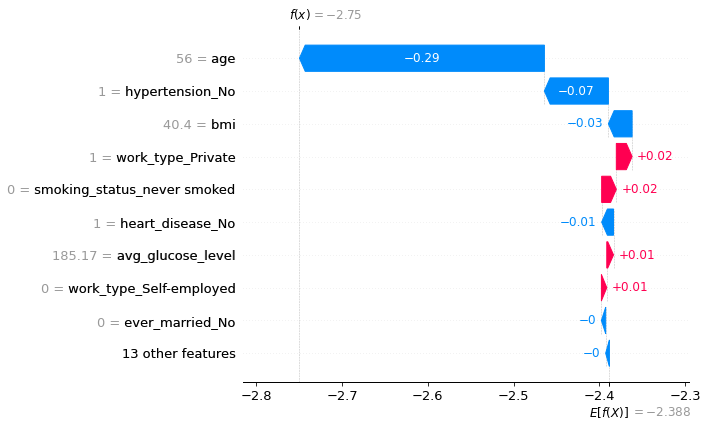

Patient id: 8154
         [Non-stroke, Stroke]
Predict: [0.8534162 0.1465838]


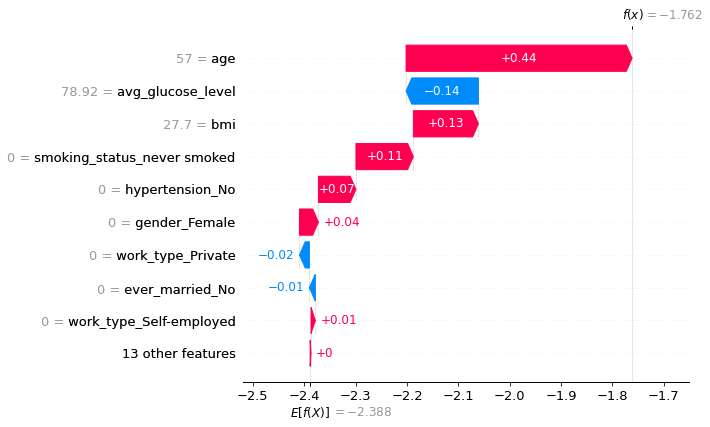

Patient id: 51169
         [Non-stroke, Stroke]
Predict: [0.6483096  0.35169044]


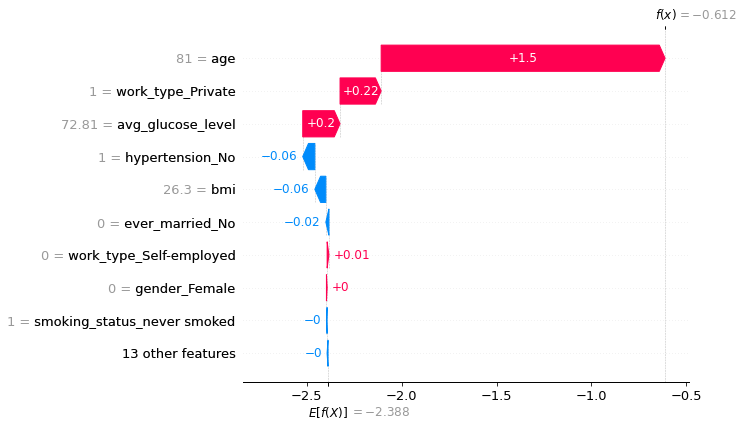

Patient id: 58202
         [Non-stroke, Stroke]
Predict: [0.8998315 0.1001685]


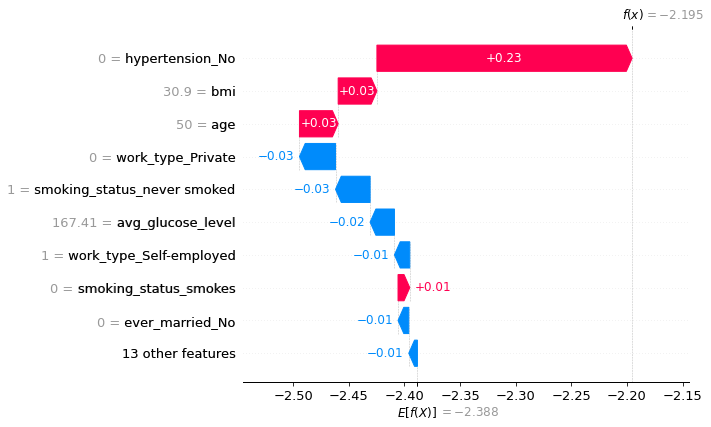

Patient id: 70042
         [Non-stroke, Stroke]
Predict: [0.81519073 0.18480925]


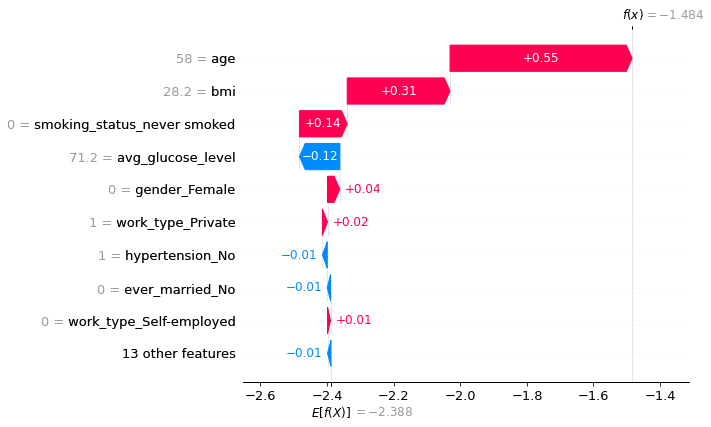

Patient id: 34120
         [Non-stroke, Stroke]
Predict: [0.82354605 0.17645392]


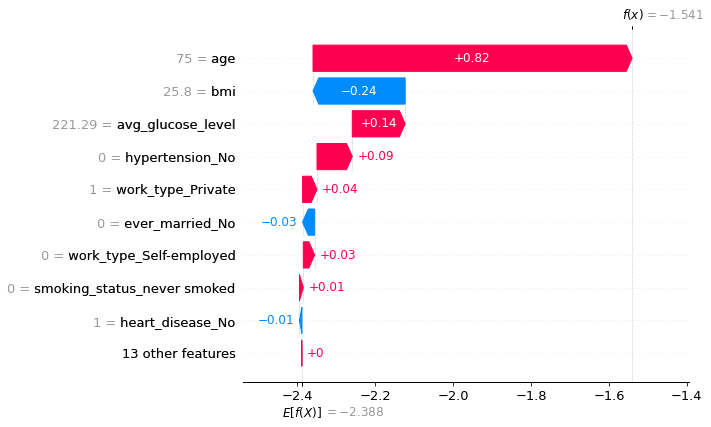

Patient id: 71639
         [Non-stroke, Stroke]
Predict: [0.8289762 0.1710238]


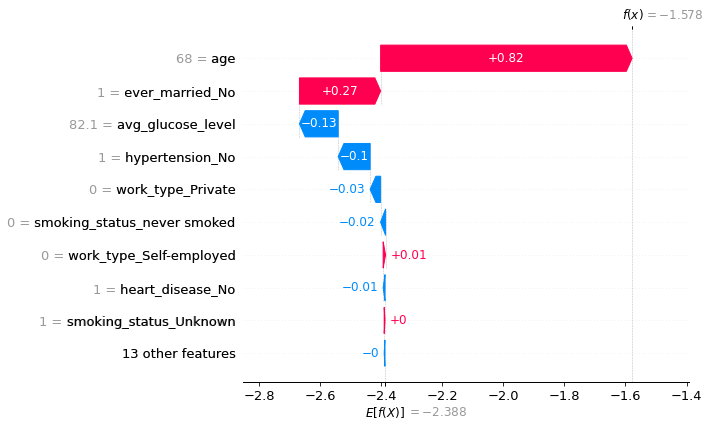

Patient id: 66258
         [Non-stroke, Stroke]
Predict: [0.8509816  0.14901842]


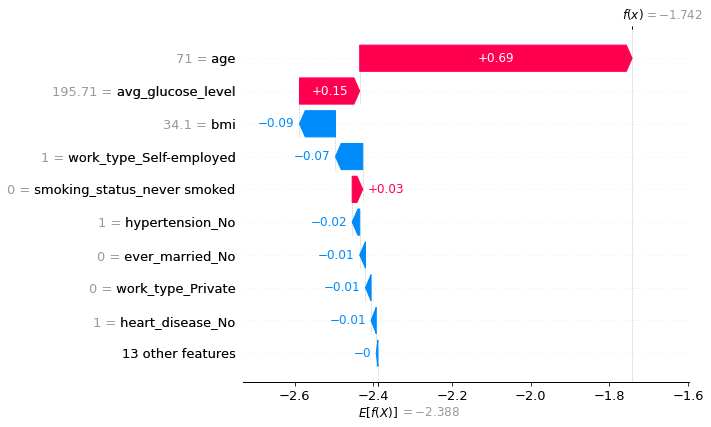

Patient id: 54724
         [Non-stroke, Stroke]
Predict: [0.8707816  0.12921841]


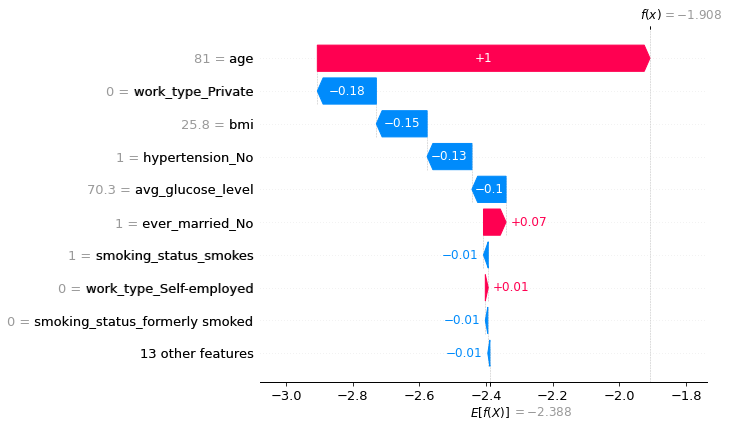

Patient id: 70676
         [Non-stroke, Stroke]
Predict: [0.75508434 0.24491565]


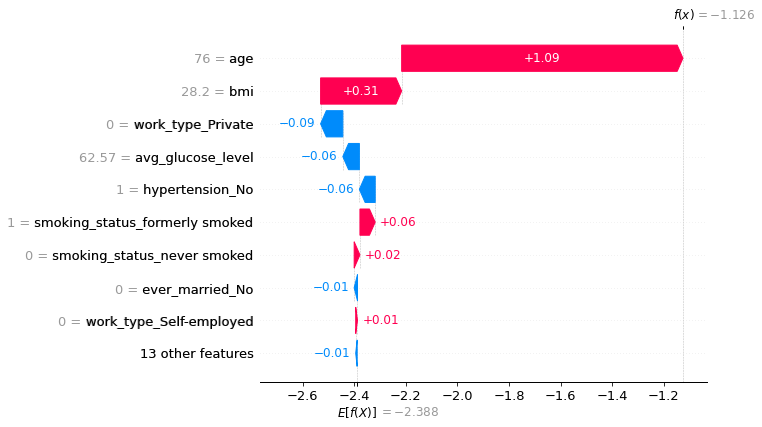

Patient id: 56939
         [Non-stroke, Stroke]
Predict: [0.9383017  0.06169833]


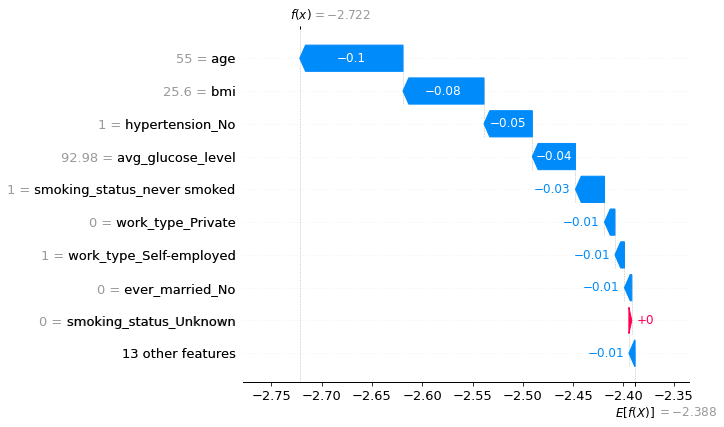

Patient id: 4712
         [Non-stroke, Stroke]
Predict: [0.83133584 0.16866414]


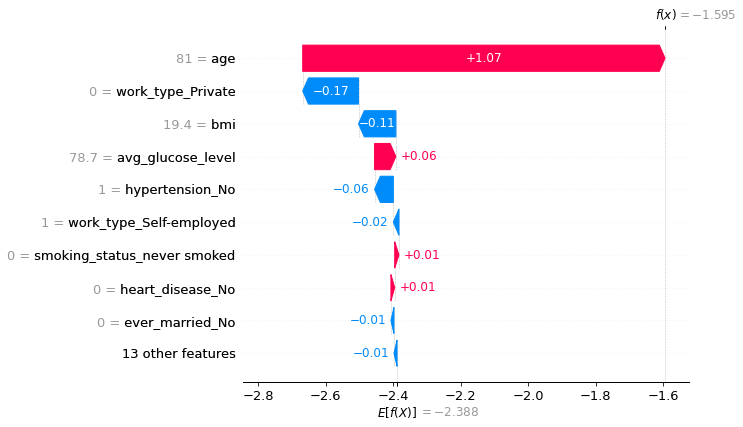

Patient id: 12062
         [Non-stroke, Stroke]
Predict: [0.9393365  0.06066355]


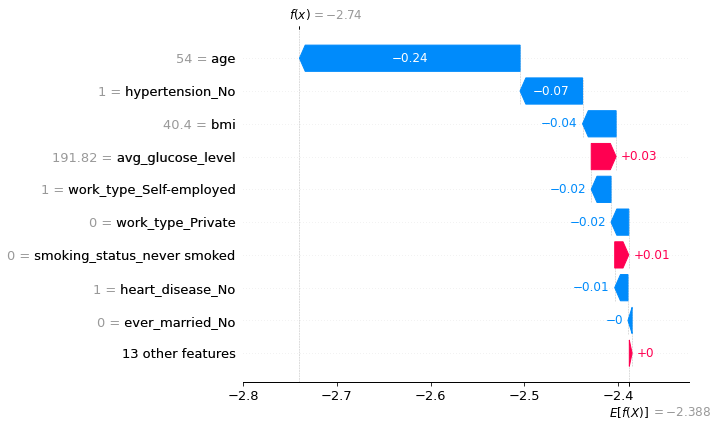

Patient id: 66204
         [Non-stroke, Stroke]
Predict: [0.8486099  0.15139008]


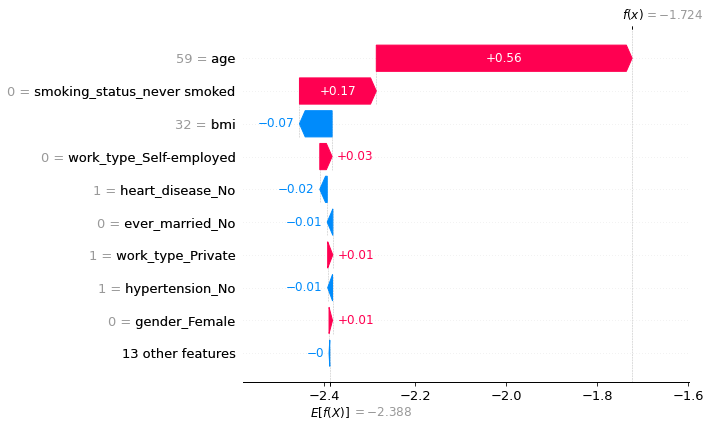

Patient id: 42117
         [Non-stroke, Stroke]
Predict: [0.95434415 0.04565584]


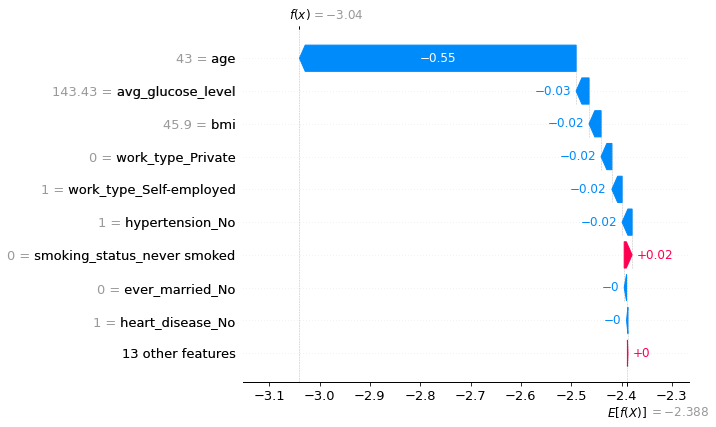

Patient id: 68794
         [Non-stroke, Stroke]
Predict: [0.84117305 0.15882696]


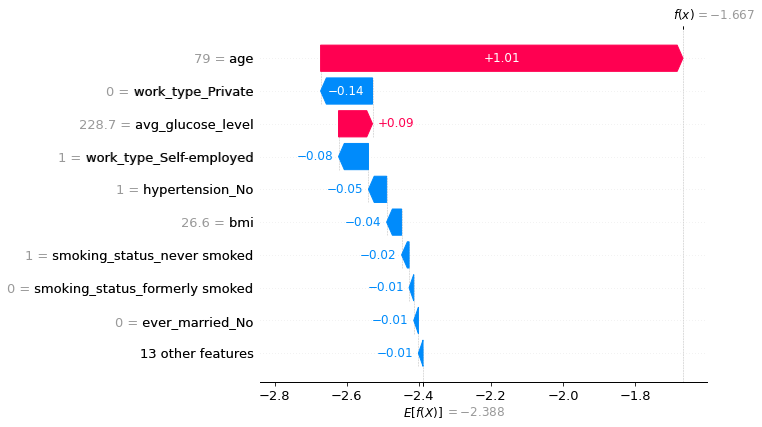

Patient id: 26727
         [Non-stroke, Stroke]
Predict: [0.7216761  0.27832392]


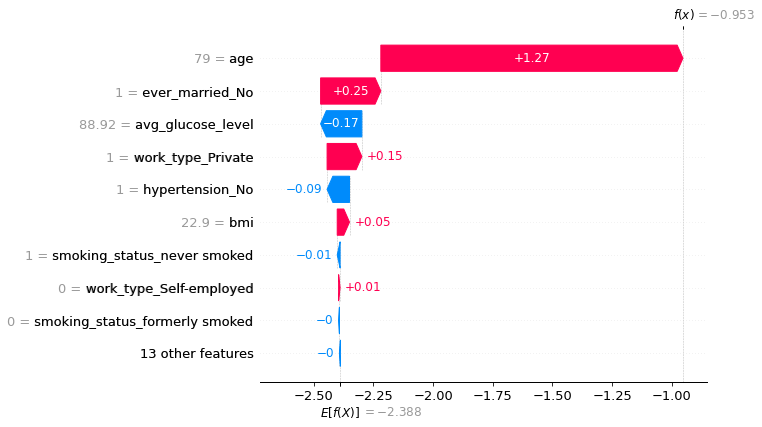

Patient id: 71673
         [Non-stroke, Stroke]
Predict: [0.7433832  0.25661677]


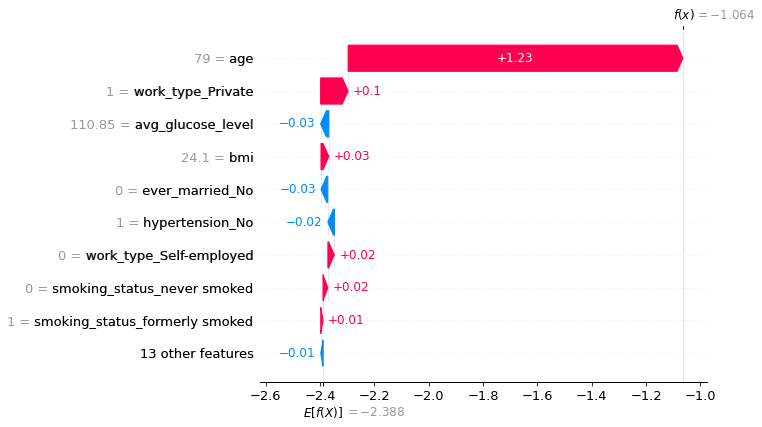

Patient id: 28378
         [Non-stroke, Stroke]
Predict: [0.8018337  0.19816633]


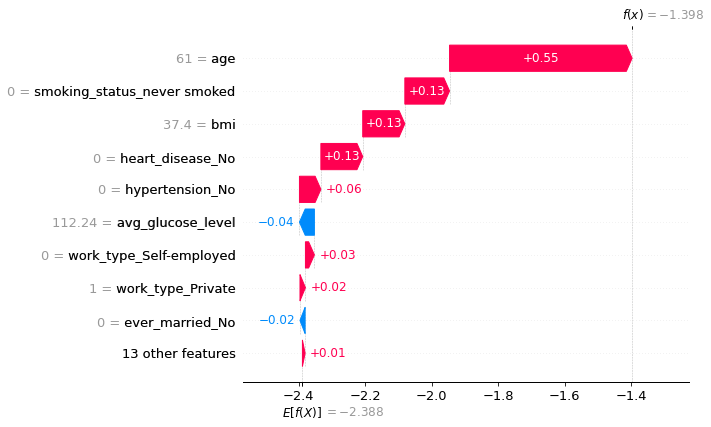

Patient id: 8899
         [Non-stroke, Stroke]
Predict: [0.9442375  0.05576253]


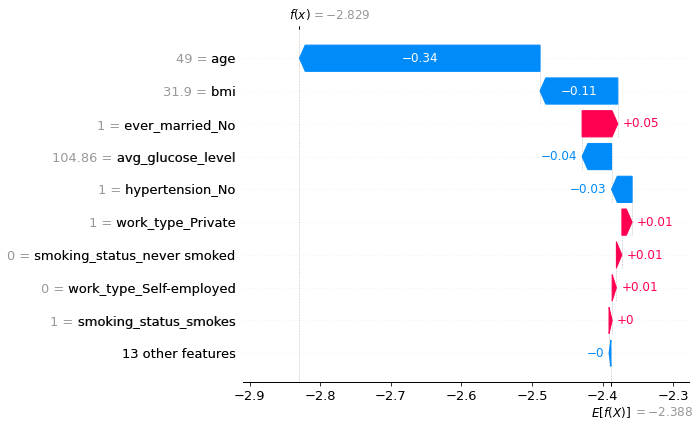

Patient id: 70630
         [Non-stroke, Stroke]
Predict: [0.84108526 0.15891473]


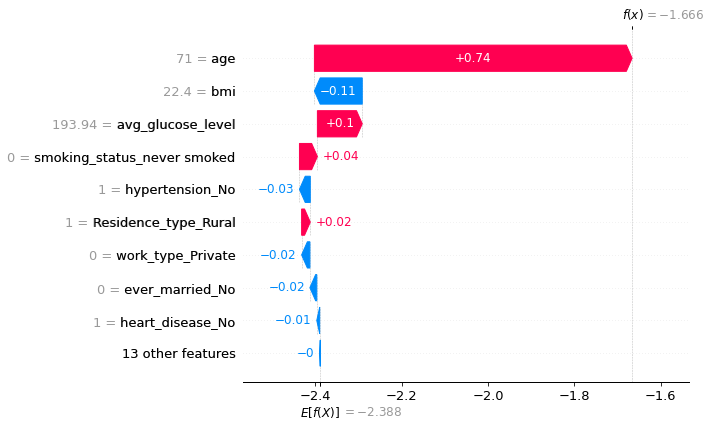

Patient id: 47306
         [Non-stroke, Stroke]
Predict: [0.88057244 0.11942757]


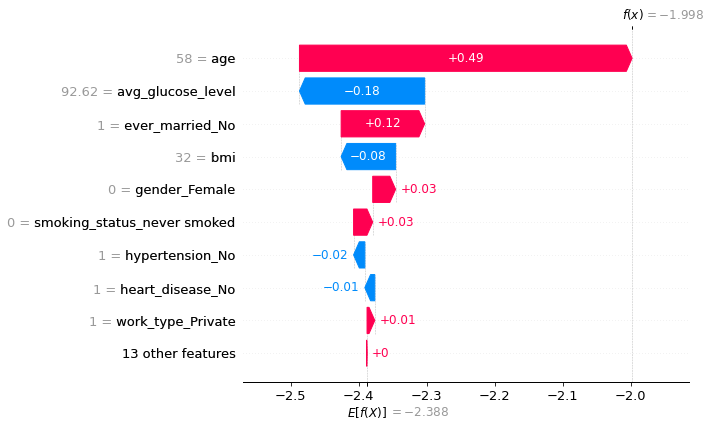

Patient id: 2390
         [Non-stroke, Stroke]
Predict: [0.84600556 0.15399441]


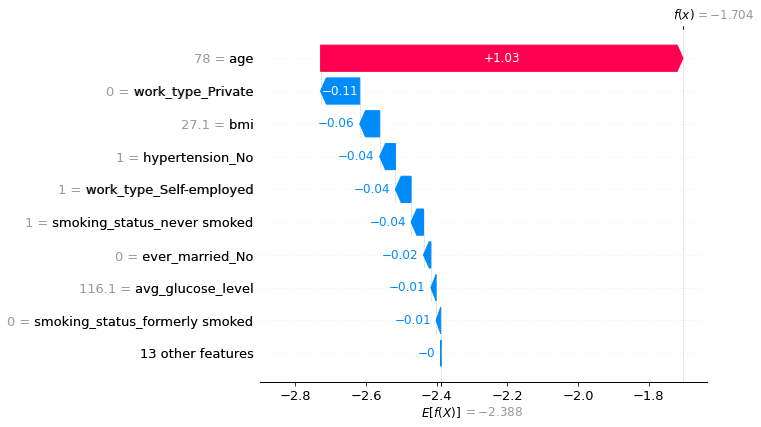

Patient id: 5563
         [Non-stroke, Stroke]
Predict: [0.7800424  0.21995762]


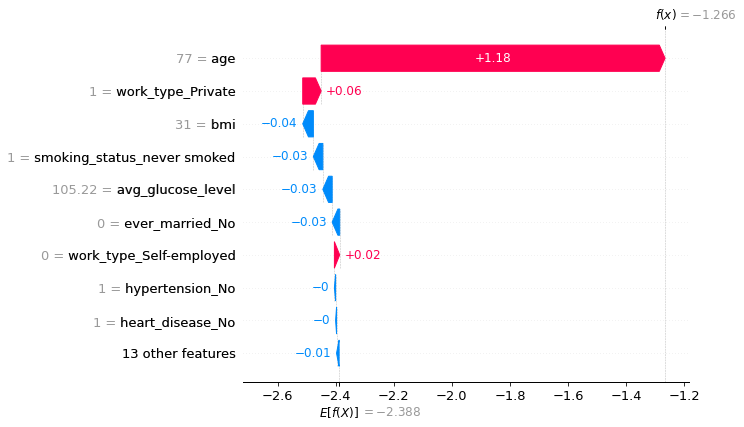

Patient id: 35578
         [Non-stroke, Stroke]
Predict: [0.85133415 0.14866585]


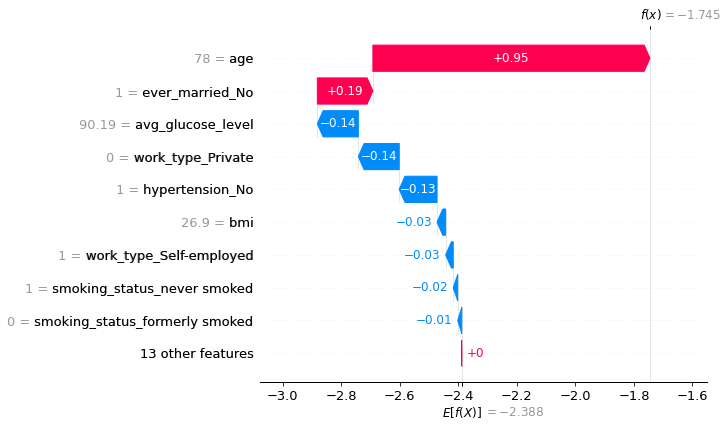

Patient id: 7356
         [Non-stroke, Stroke]
Predict: [0.7627975  0.23720251]


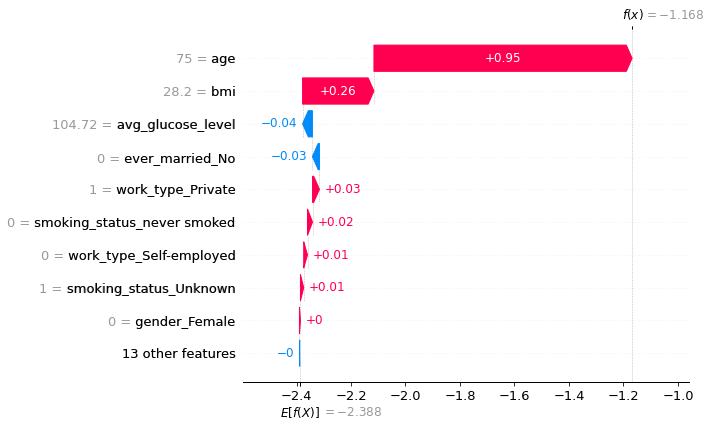

Patient id: 8580
         [Non-stroke, Stroke]
Predict: [0.8664273  0.13357267]


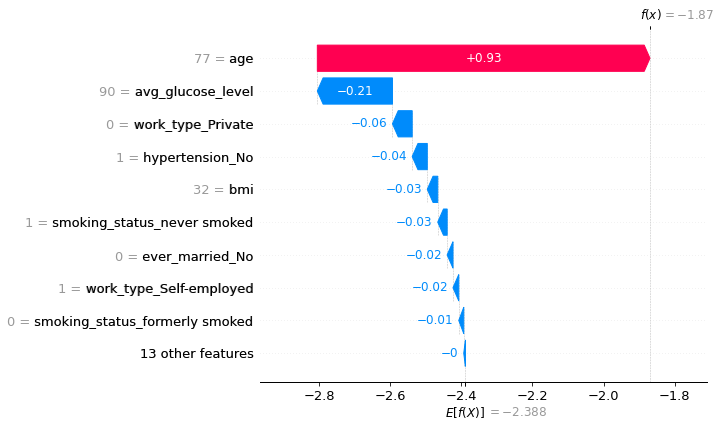

Patient id: 54921
         [Non-stroke, Stroke]
Predict: [0.8032967 0.1967033]


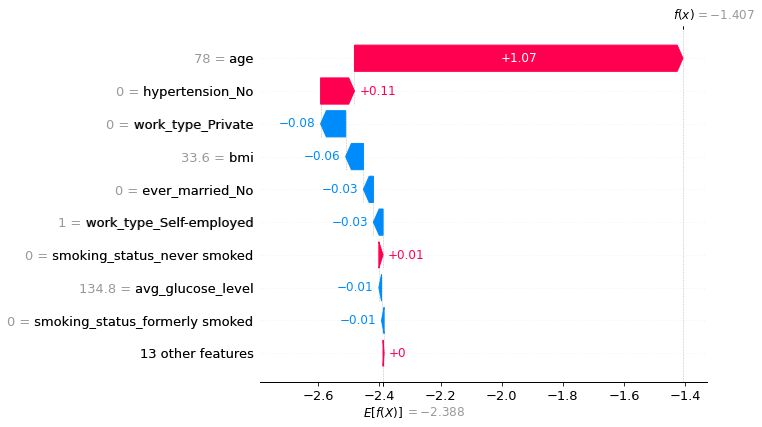

Patient id: 31720
         [Non-stroke, Stroke]
Predict: [0.9527966 0.0472034]


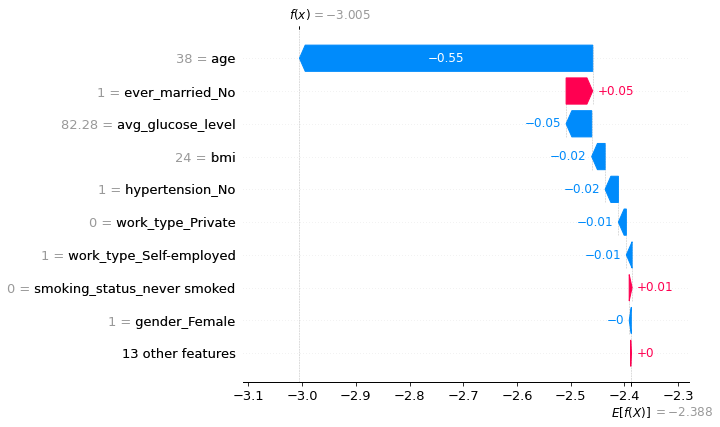

Patient id: 49130
         [Non-stroke, Stroke]
Predict: [0.8871584  0.11284161]


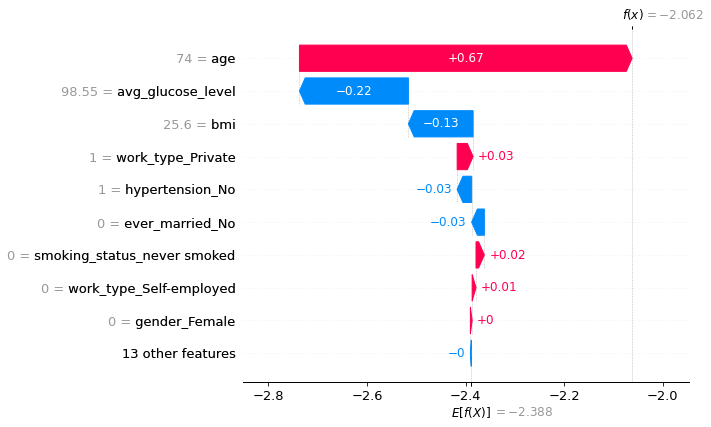

Patient id: 16077
         [Non-stroke, Stroke]
Predict: [0.88528085 0.11471918]


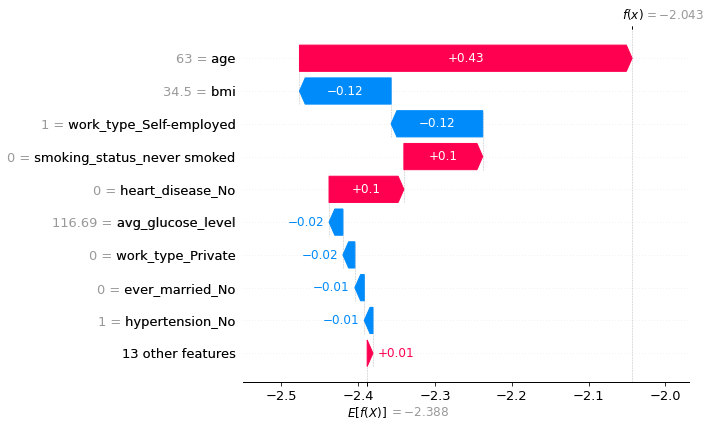

Patient id: 13861
         [Non-stroke, Stroke]
Predict: [0.8584502  0.14154983]


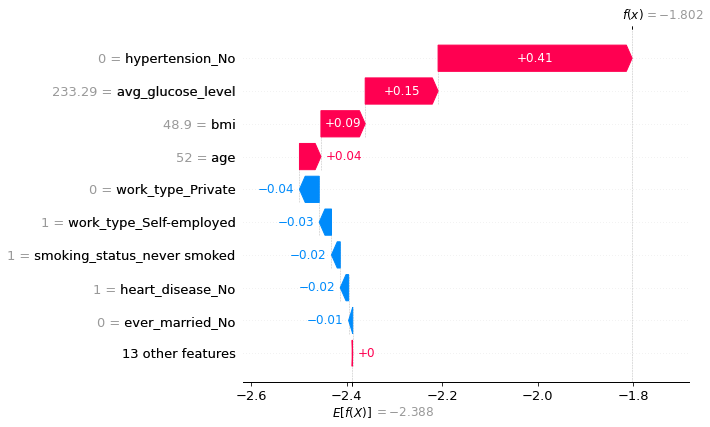

Patient id: 14164
         [Non-stroke, Stroke]
Predict: [0.70440984 0.29559016]


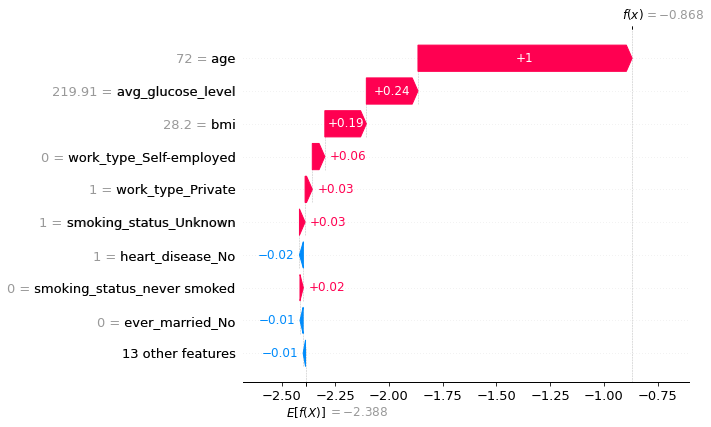

Patient id: 32221
         [Non-stroke, Stroke]
Predict: [0.8976111  0.10238893]


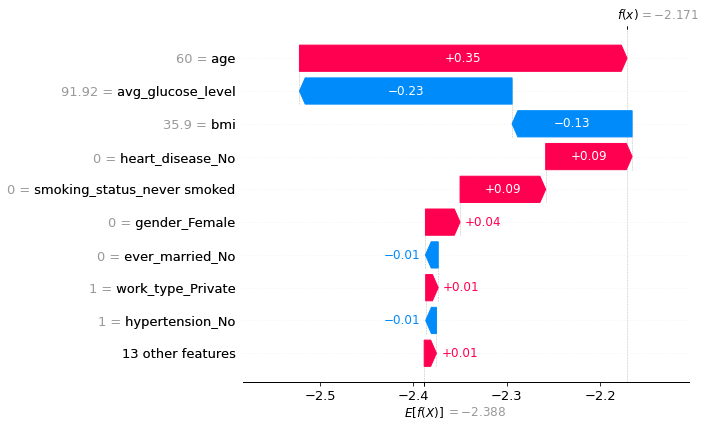

Patient id: 13491
         [Non-stroke, Stroke]
Predict: [0.4821251 0.5178749]


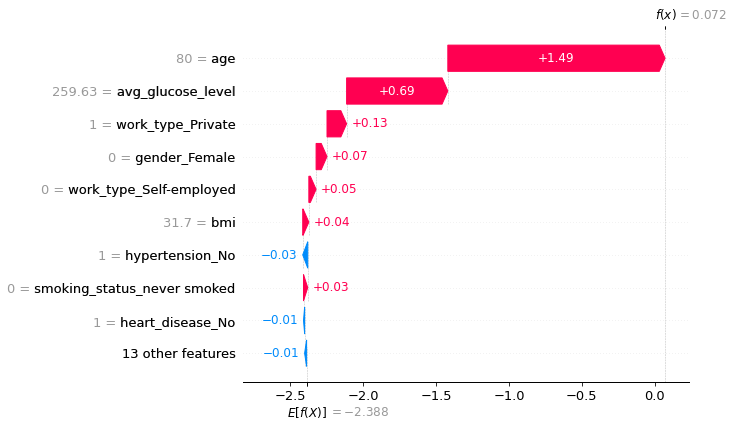

Patient id: 10552
         [Non-stroke, Stroke]
Predict: [0.8626597  0.13734032]


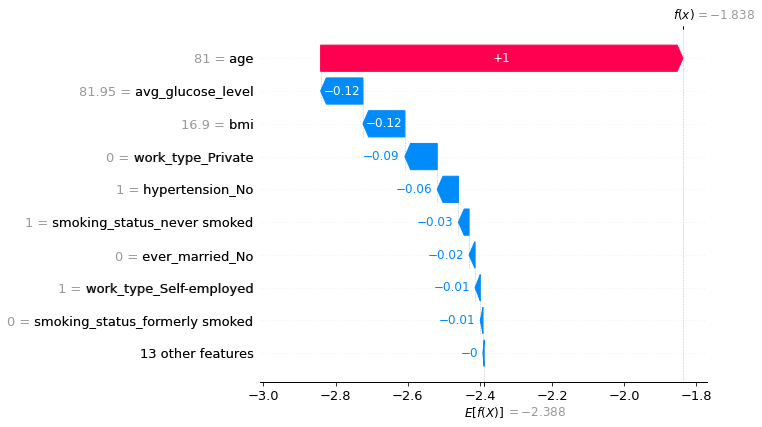

Patient id: 28939
         [Non-stroke, Stroke]
Predict: [0.83765584 0.16234416]


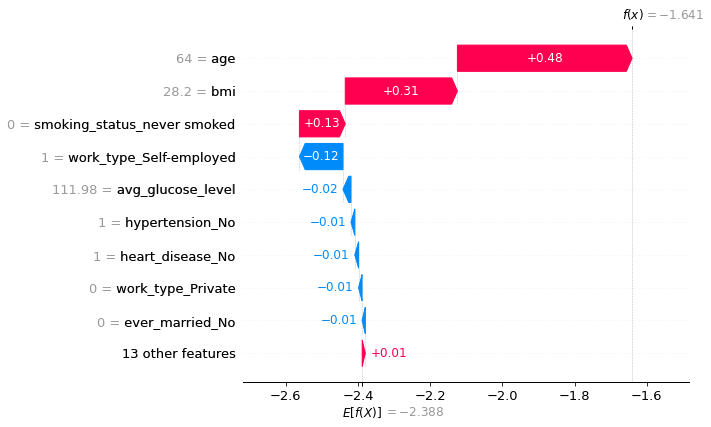

Patient id: 34060
         [Non-stroke, Stroke]
Predict: [0.80267787 0.19732216]


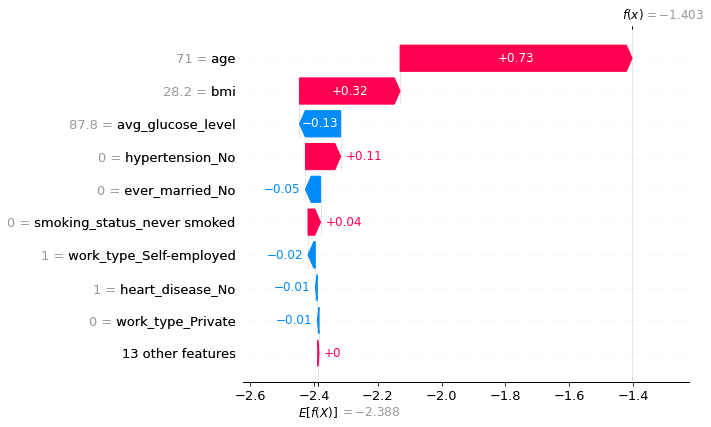

Patient id: 41069
         [Non-stroke, Stroke]
Predict: [0.9425443  0.05745572]


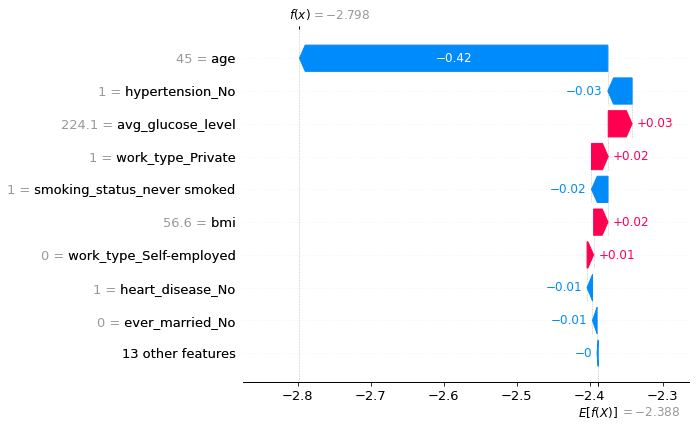

Patient id: 23368
         [Non-stroke, Stroke]
Predict: [0.7064809  0.29351908]


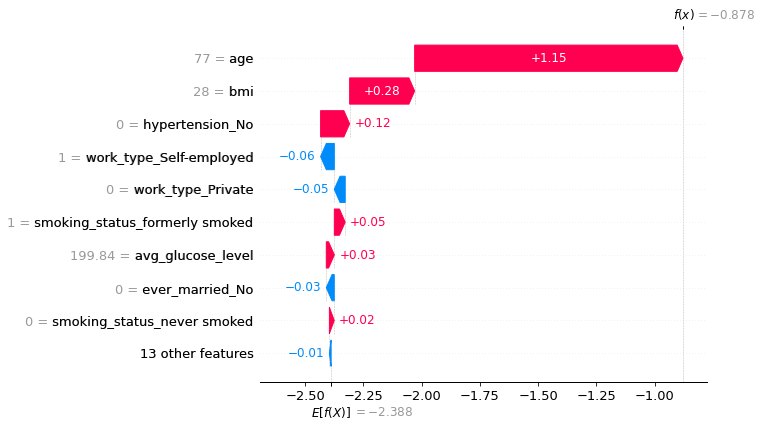

In [37]:
map_ = ['Non-Stroke', 'Stroke']
for i in y_test[y_test==1].index:
    print(f'Patient id: {X_test_id[i]}')
    print('         [Non-stroke, Stroke]')
    print(f'Predict: {xgb_pred_test[i]}')
    shap.plots.waterfall(shap_values[i])

14
Predict: [0.87939274 0.12060724]


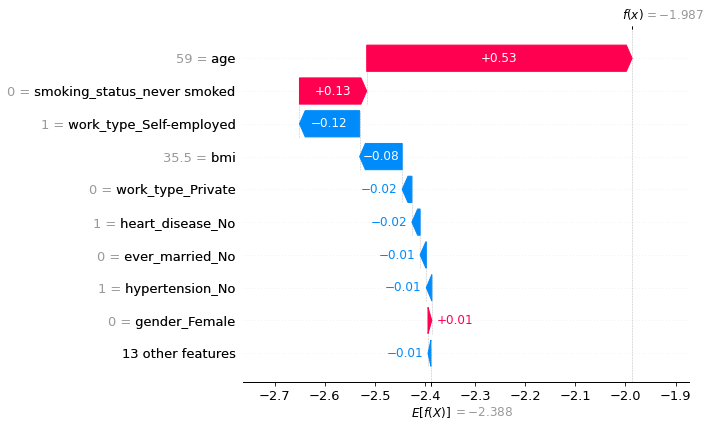

26
Predict: [0.7941427  0.20585729]


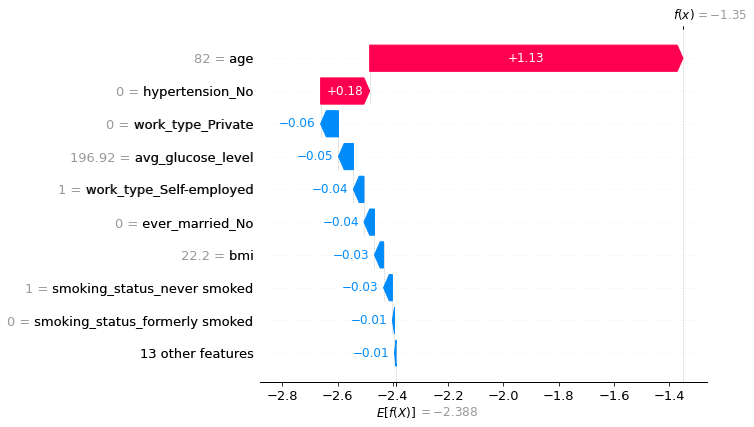

27
Predict: [0.7811903 0.2188097]


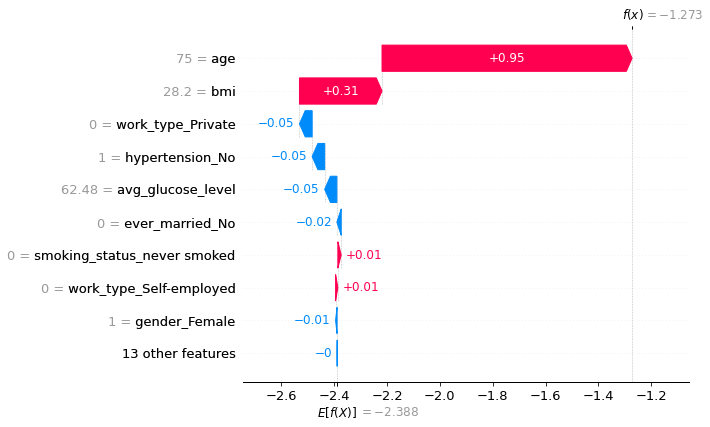

57
Predict: [0.7654866 0.2345134]


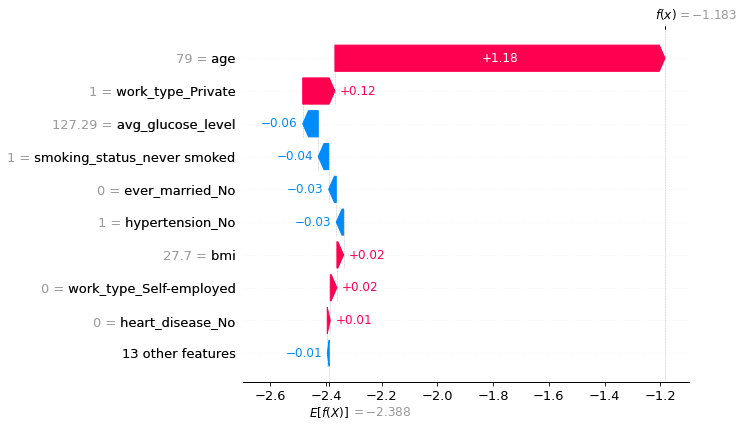

81
Predict: [0.6778446  0.32215542]


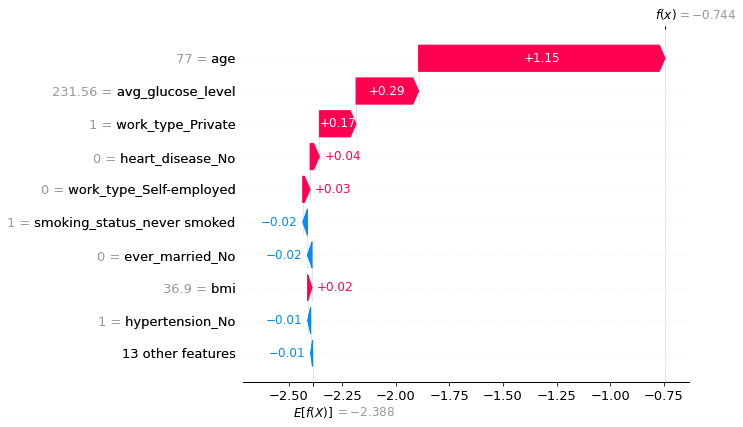

103
Predict: [0.8657713 0.1342287]


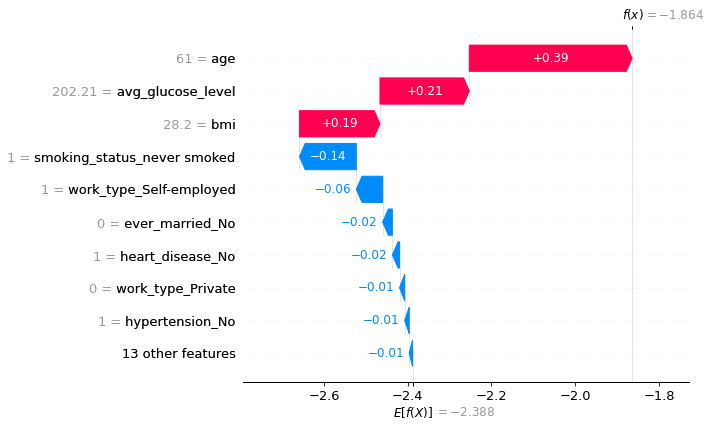

120
Predict: [0.57126766 0.42873234]


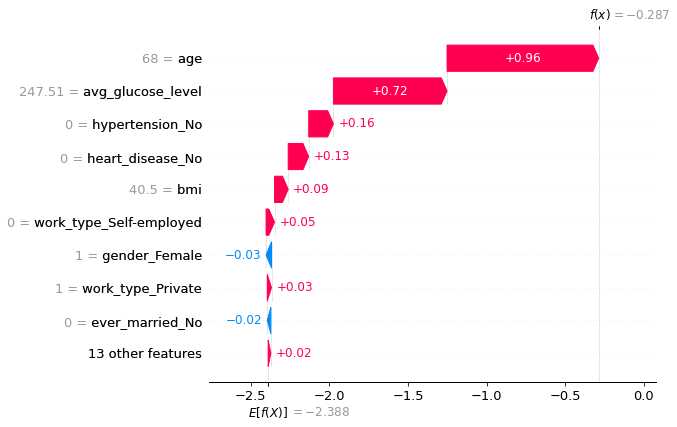

140
Predict: [0.93545145 0.06454855]


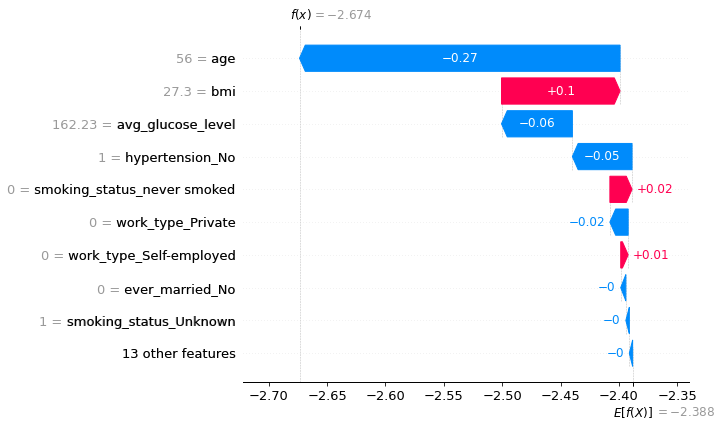

182
Predict: [0.81778634 0.18221368]


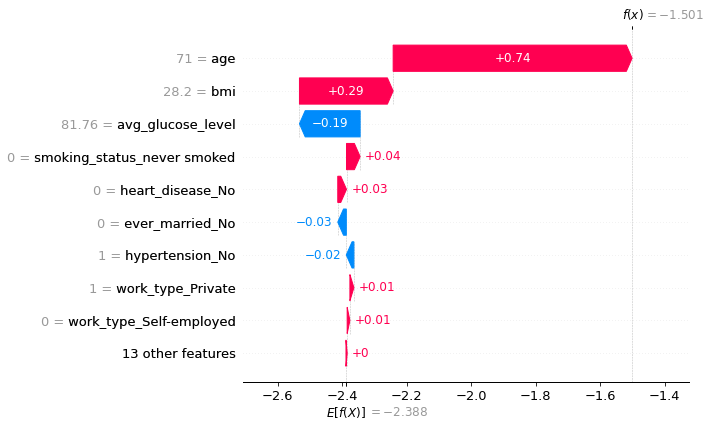

190
Predict: [0.8403415 0.1596585]


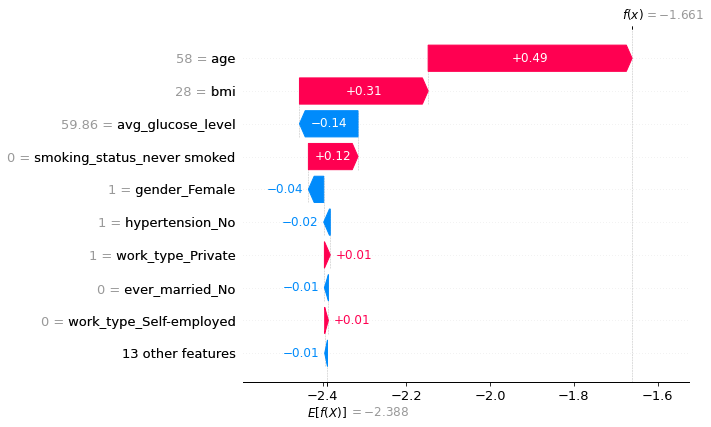

191
Predict: [0.9398946  0.06010536]


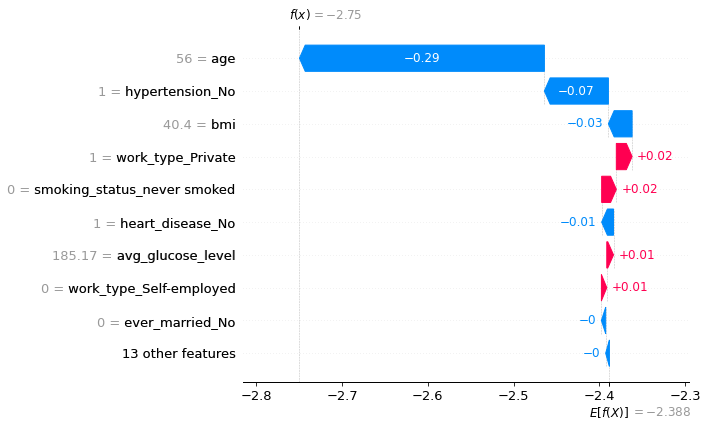

201
Predict: [0.8534162 0.1465838]


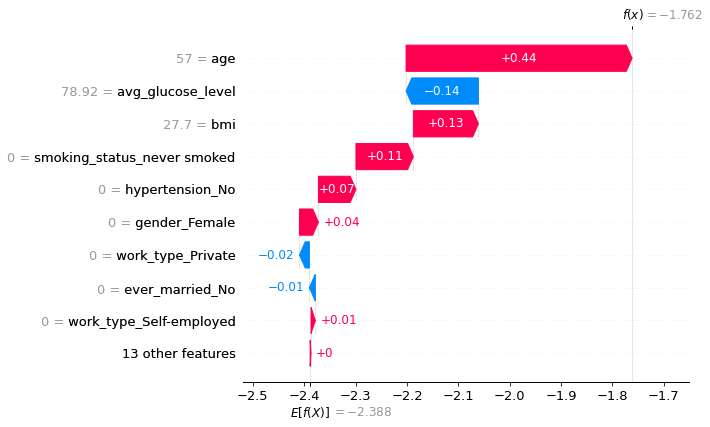

204
Predict: [0.6483096  0.35169044]


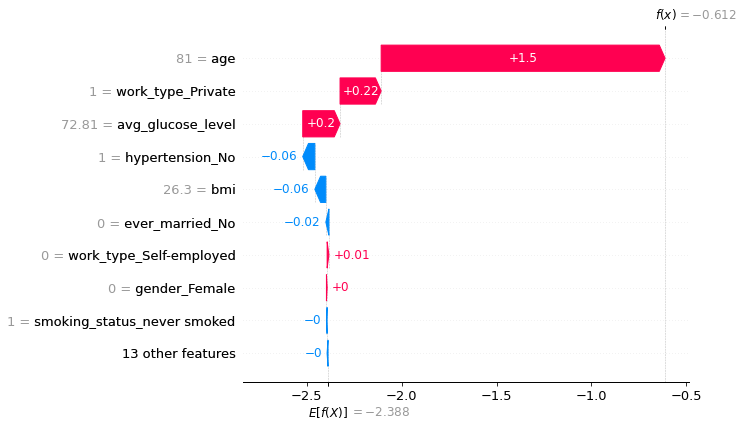

222
Predict: [0.8998315 0.1001685]


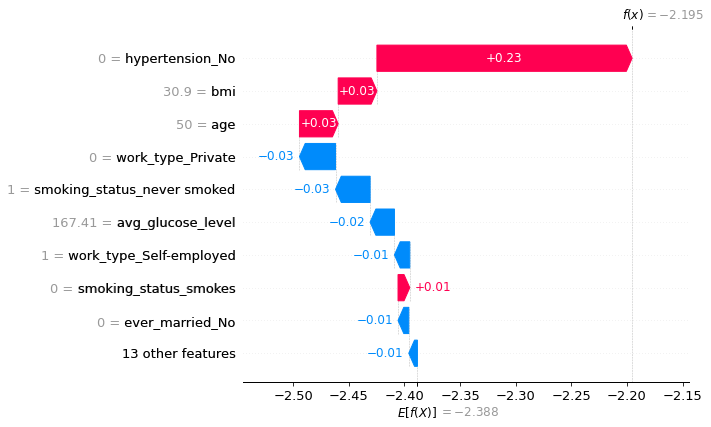

255
Predict: [0.81519073 0.18480925]


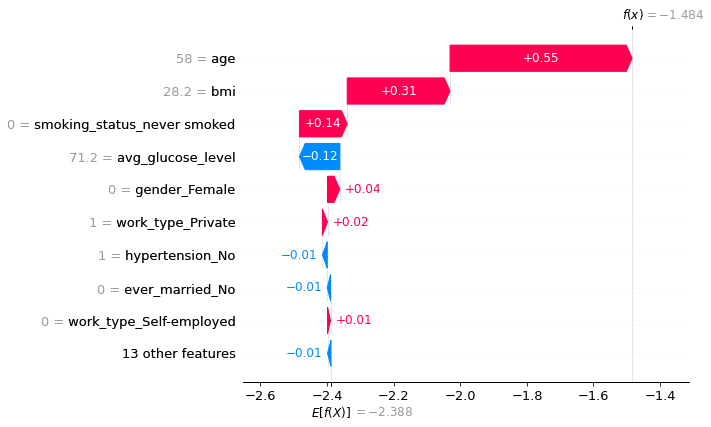

282
Predict: [0.82354605 0.17645392]


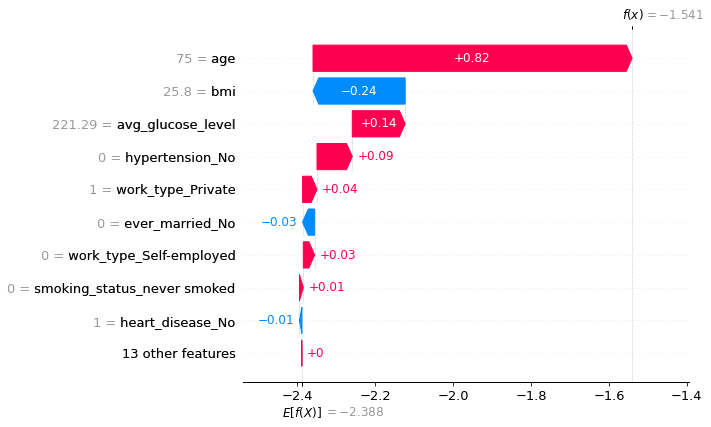

338
Predict: [0.8289762 0.1710238]


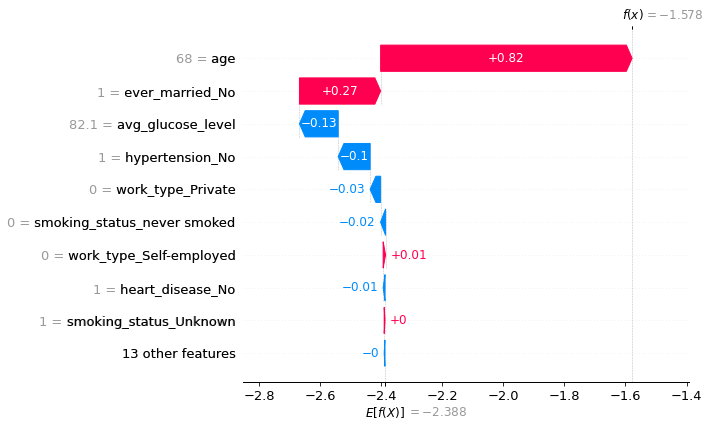

368
Predict: [0.8509816  0.14901842]


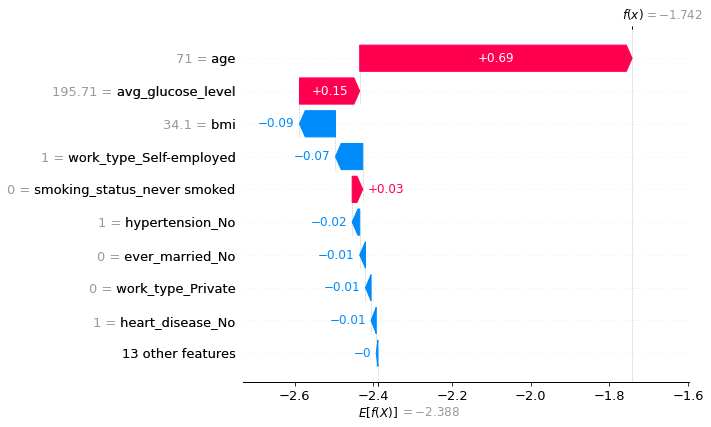

369
Predict: [0.8707816  0.12921841]


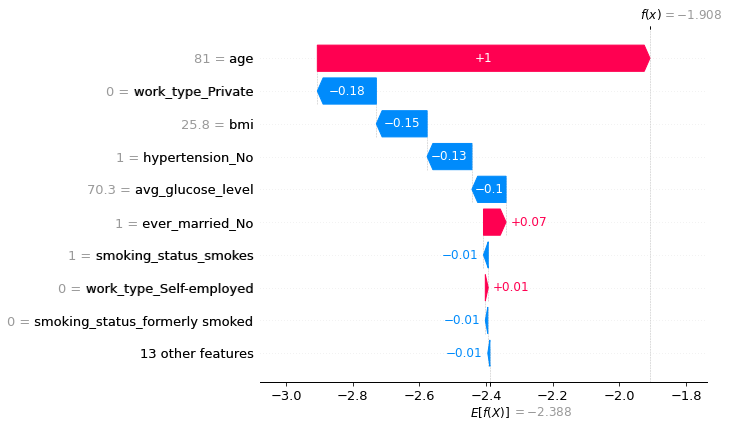

382
Predict: [0.75508434 0.24491565]


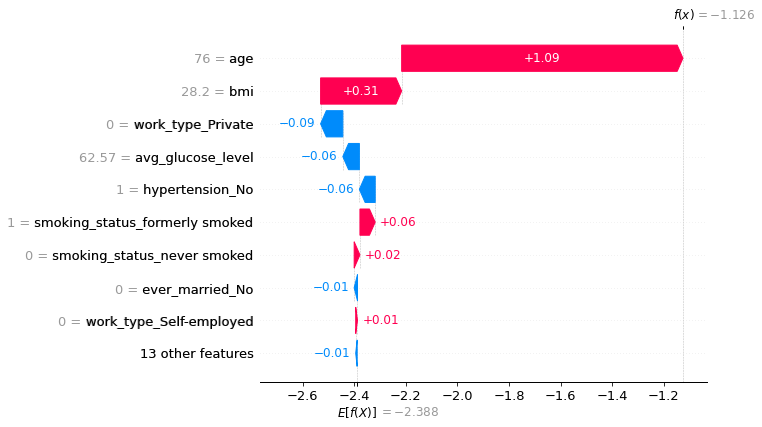

409
Predict: [0.9383017  0.06169833]


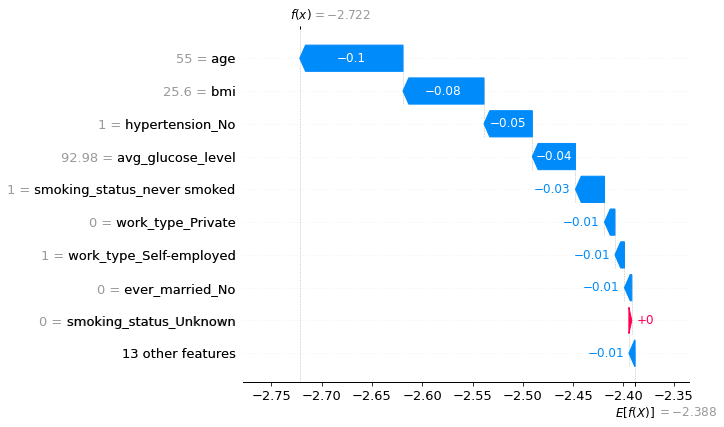

412
Predict: [0.83133584 0.16866414]


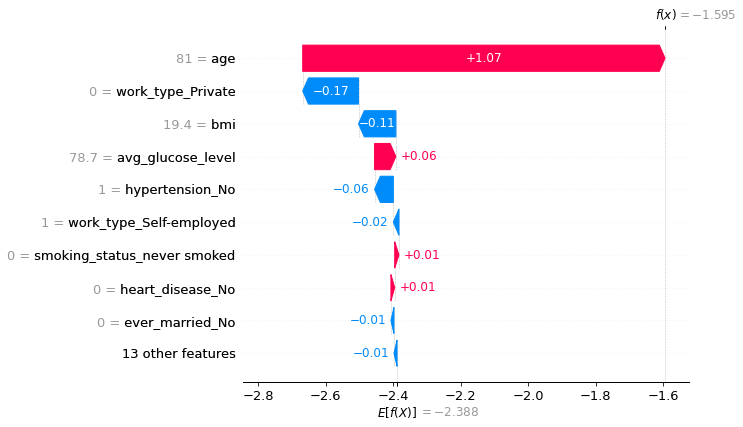

442
Predict: [0.9393365  0.06066355]


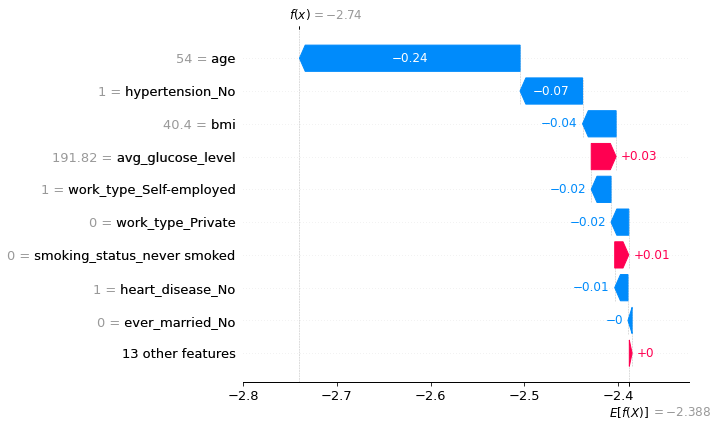

541
Predict: [0.8486099  0.15139008]


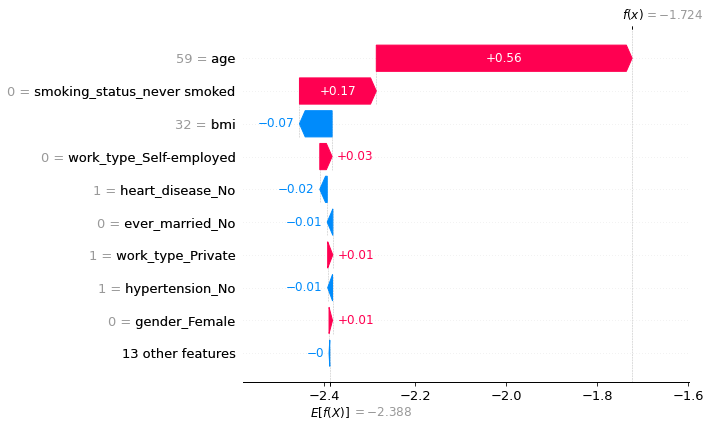

572
Predict: [0.95434415 0.04565584]


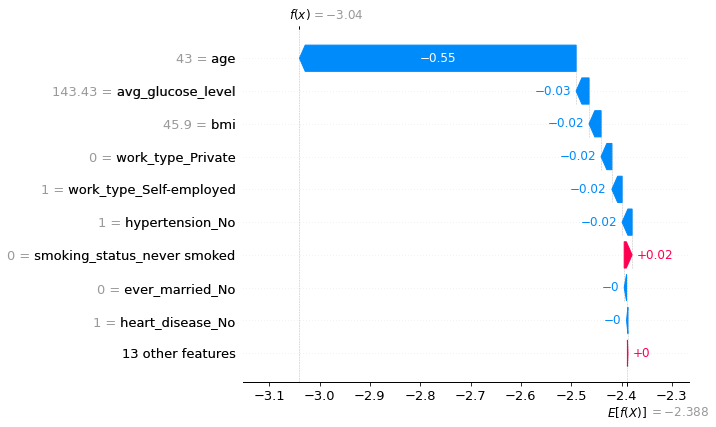

573
Predict: [0.84117305 0.15882696]


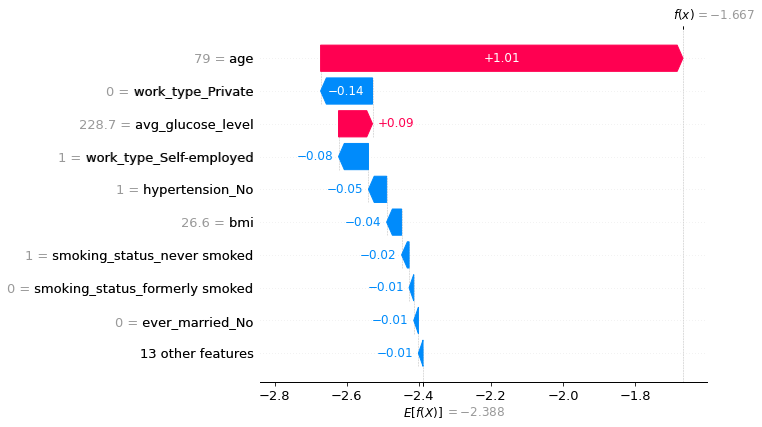

583
Predict: [0.7216761  0.27832392]


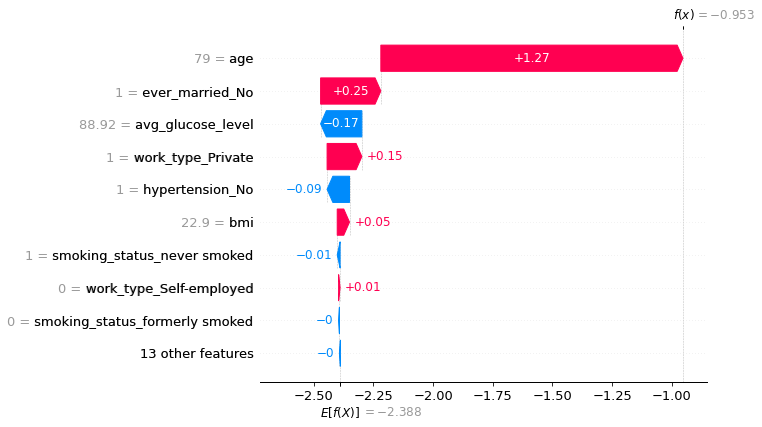

598
Predict: [0.7433832  0.25661677]


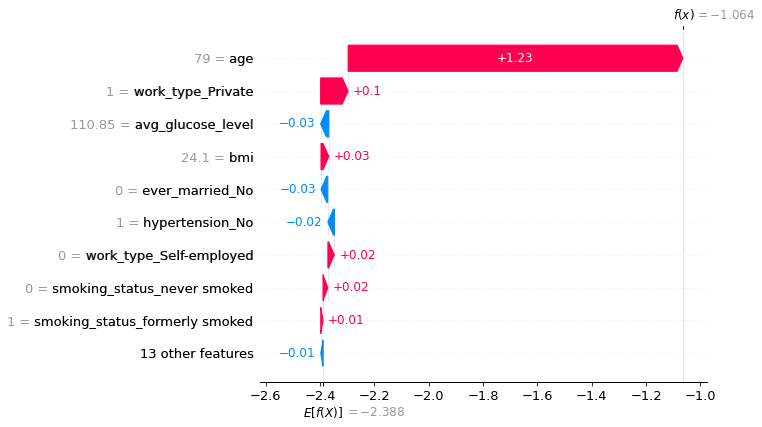

603
Predict: [0.8018337  0.19816633]


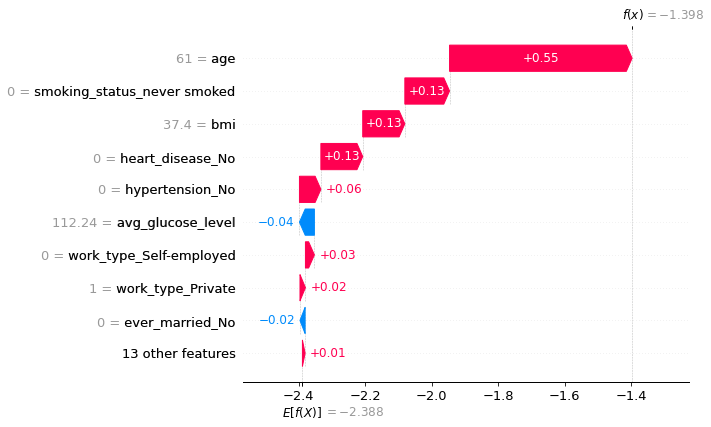

621
Predict: [0.9442375  0.05576253]


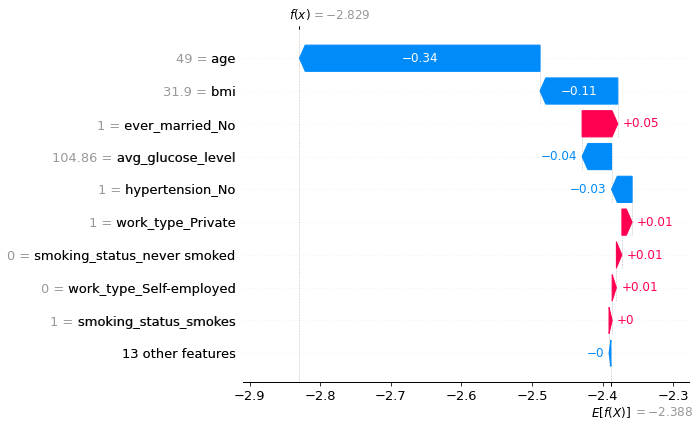

662
Predict: [0.84108526 0.15891473]


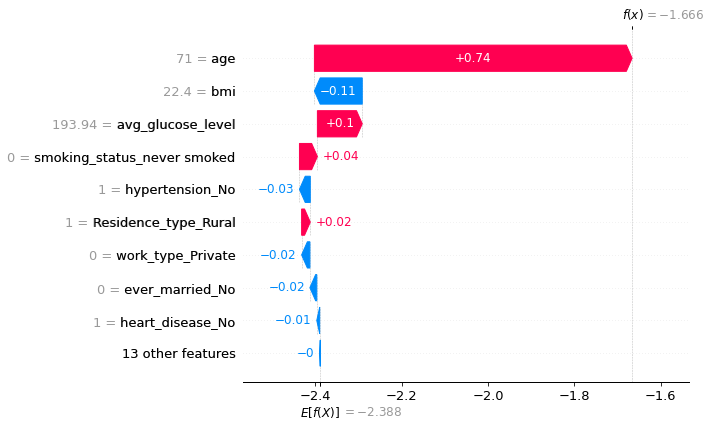

672
Predict: [0.88057244 0.11942757]


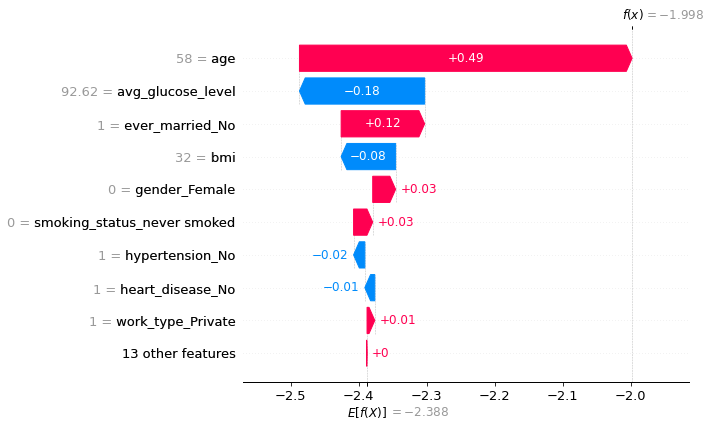

695
Predict: [0.84600556 0.15399441]


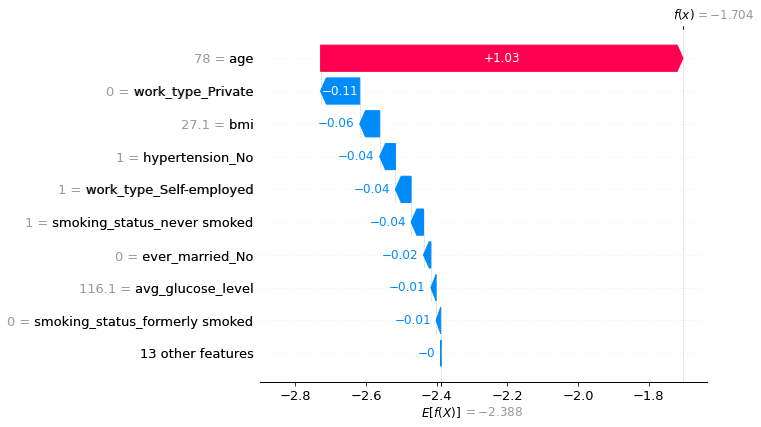

729
Predict: [0.7800424  0.21995762]


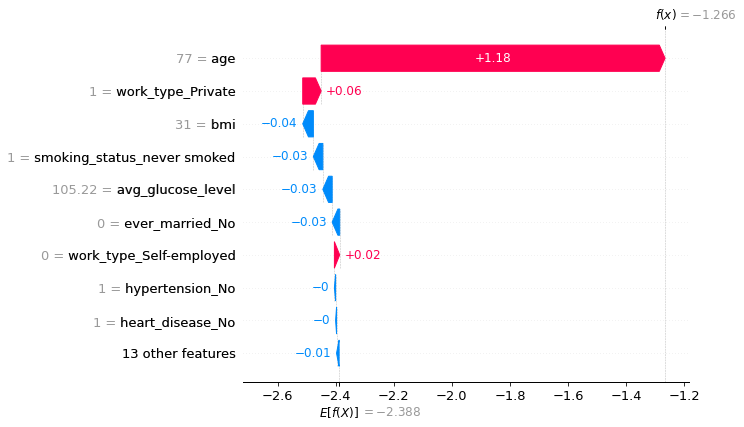

733
Predict: [0.85133415 0.14866585]


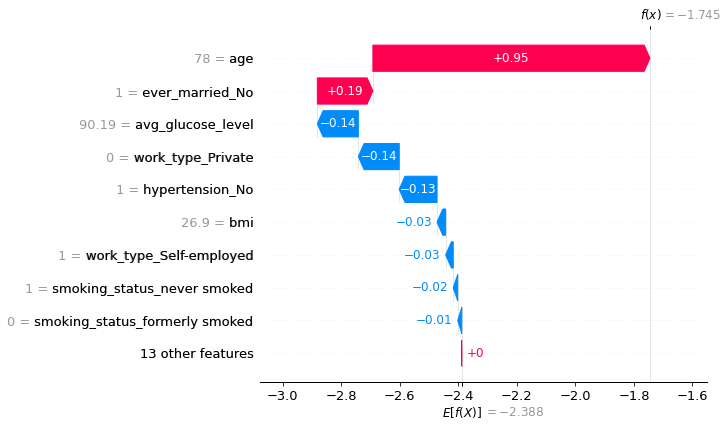

756
Predict: [0.7627975  0.23720251]


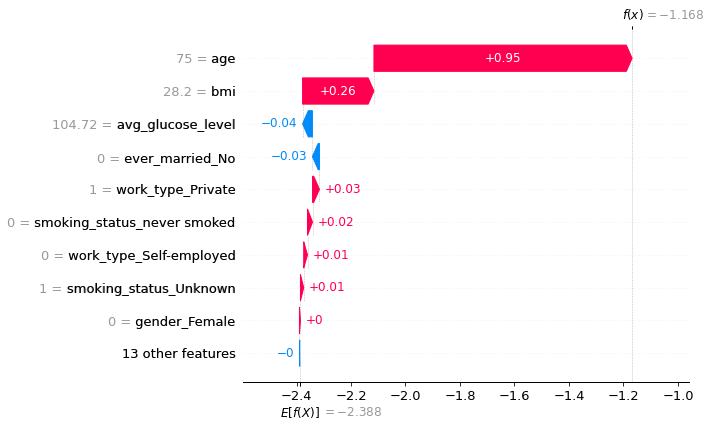

801
Predict: [0.8664273  0.13357267]


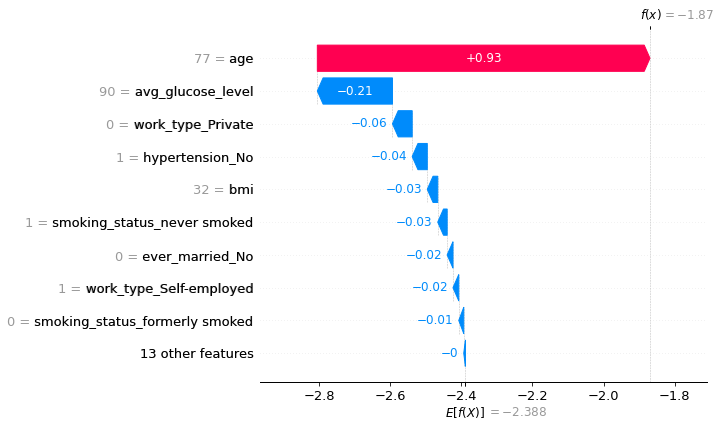

827
Predict: [0.8032967 0.1967033]


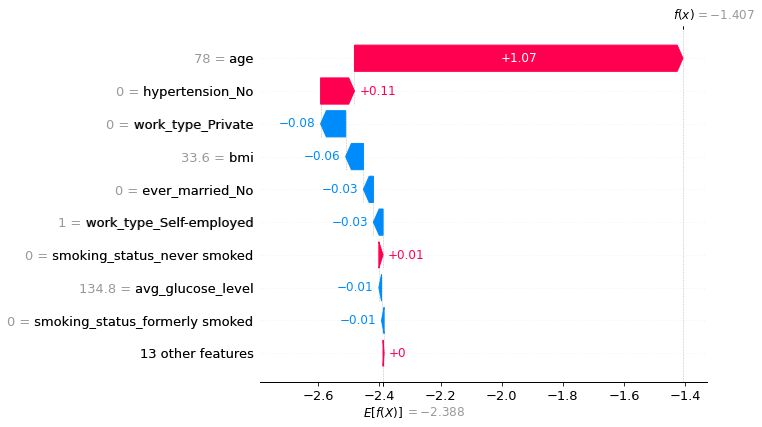

846
Predict: [0.9527966 0.0472034]


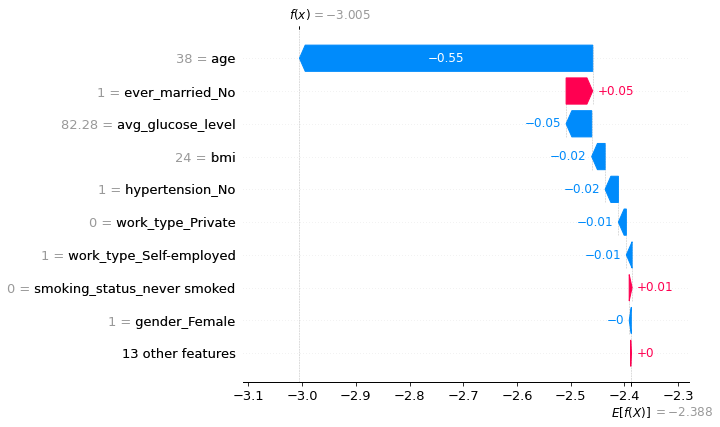

865
Predict: [0.8871584  0.11284161]


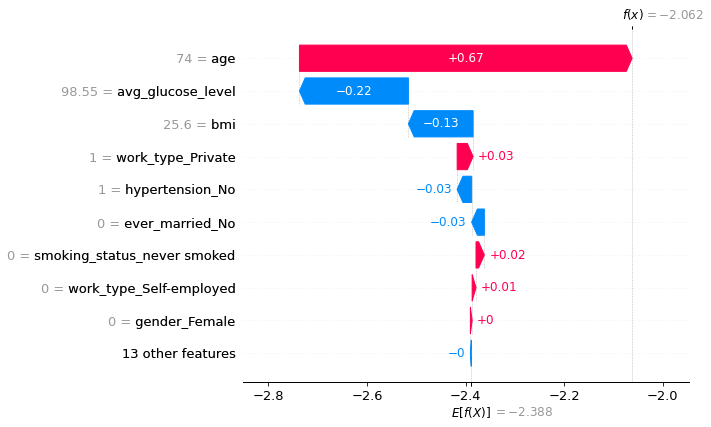

867
Predict: [0.88528085 0.11471918]


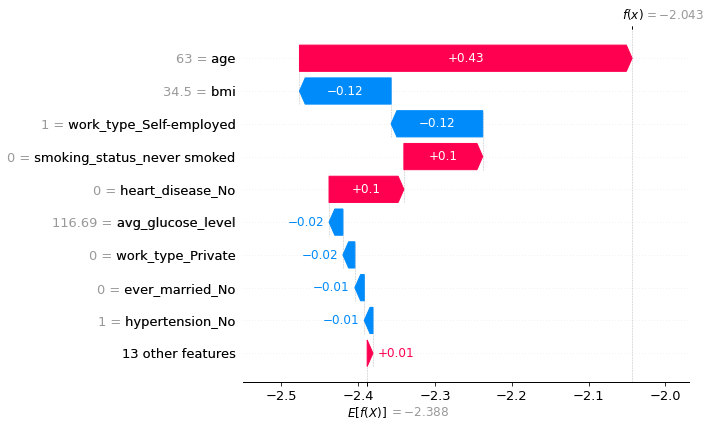

872
Predict: [0.8584502  0.14154983]


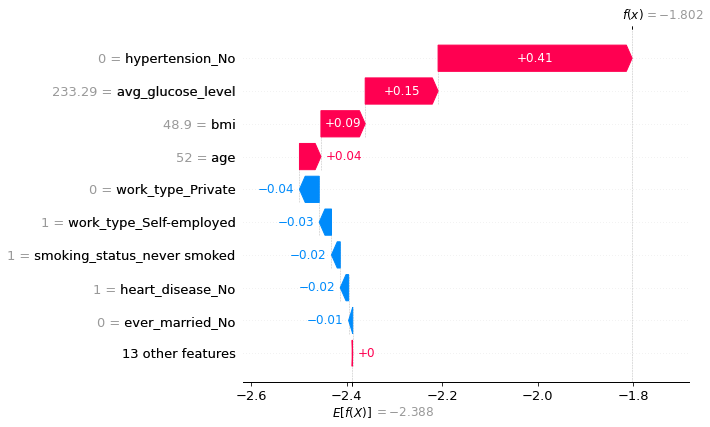

876
Predict: [0.70440984 0.29559016]


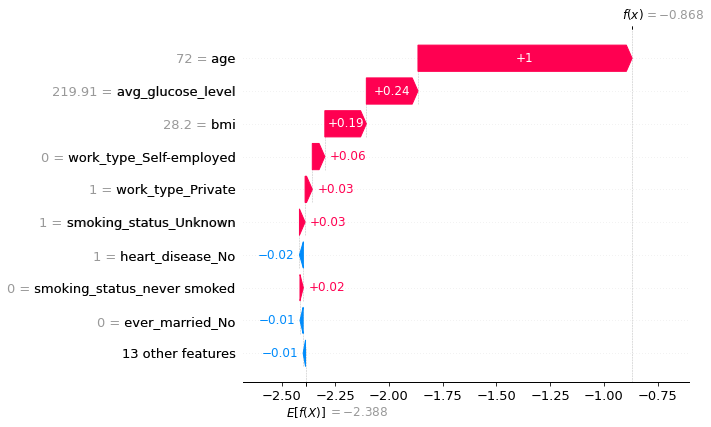

881
Predict: [0.8976111  0.10238893]


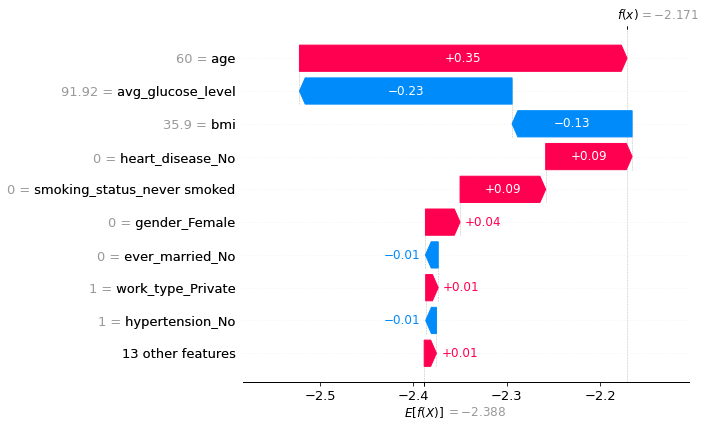

899
Predict: [0.4821251 0.5178749]


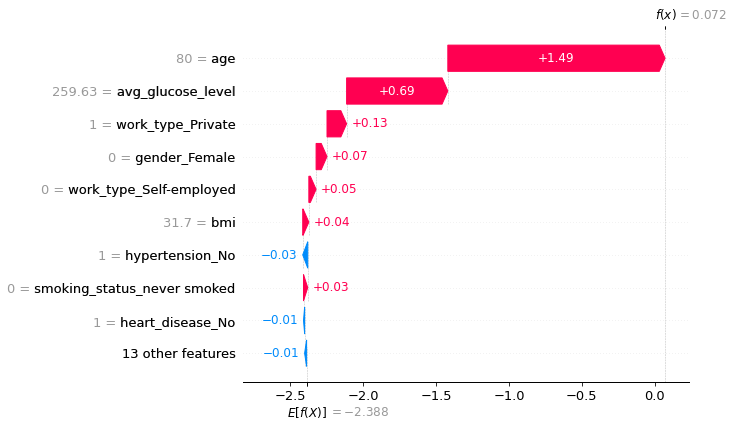

907
Predict: [0.8626597  0.13734032]


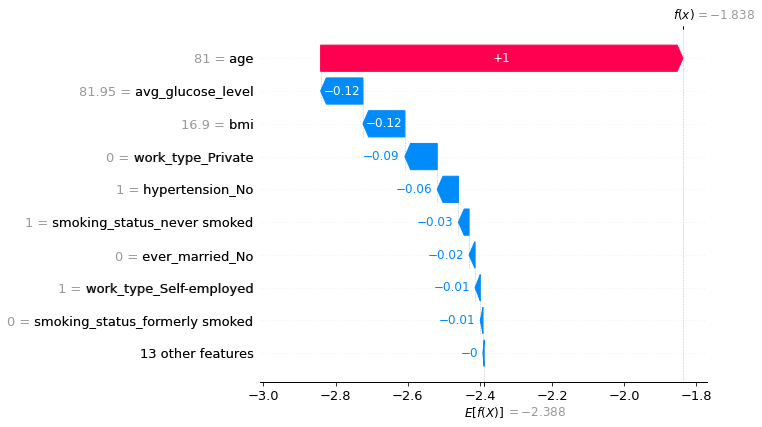

911
Predict: [0.83765584 0.16234416]


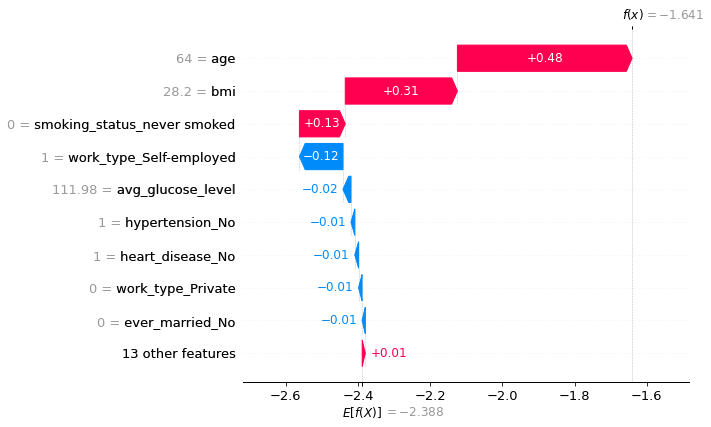

916
Predict: [0.80267787 0.19732216]


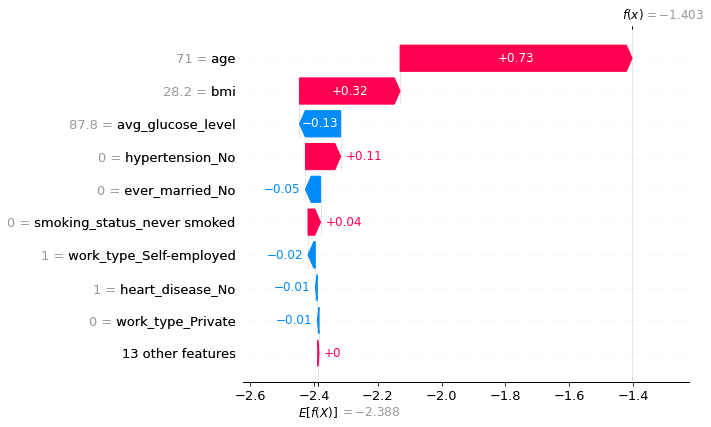

976
Predict: [0.9425443  0.05745572]


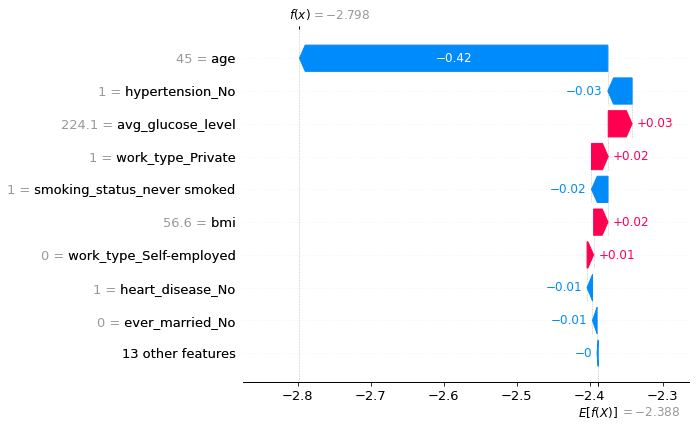

1020
Predict: [0.7064809  0.29351908]


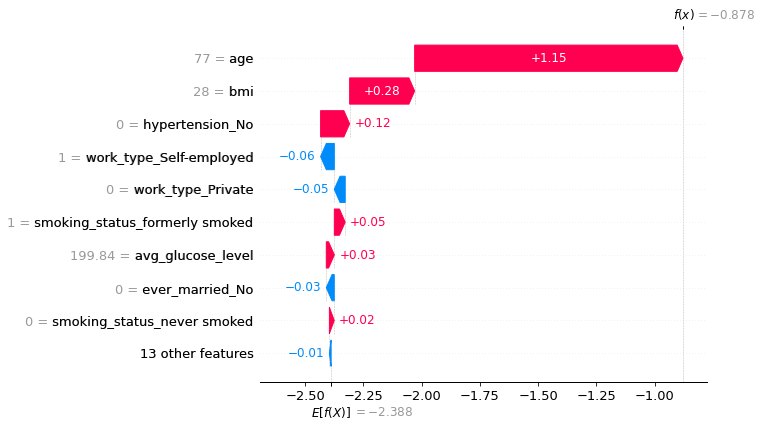

In [42]:
map_ = ['Non-Stroke', 'Stroke']
for i in y_test[y_test==1].index:
    print(i)
    print(f'Predict: {xgb_pred_test[i]}')
    shap.plots.waterfall(shap_values[i])

In [ ]:
shap.plots.waterfall(shap_values[0])